In [ ]:
import time
from sklearn.ensemble import ExtraTreesRegressor, VotingClassifier
import sklearn.neural_network
import sklearn.preprocessing, sklearn.feature_selection, sklearn.model_selection, sklearn.tree, sklearn.metrics, sklearn.ensemble, sklearn.linear_model, sklearn.neighbors, sklearn.svm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
plt.style.use('seaborn')
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, MinMaxScaler

from google.colab import drive
drive.mount('/content/drive/')

<ipython-input-1-20705ddbdec5>:9: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


Mounted at /content/drive/


In [ ]:
data = pd.read_csv('/content/drive/MyDrive/Abc/wustl-ehms-2020_with_attacks_categories.csv')

In [ ]:
data.isna().sum()

Dir                0
Flgs               0
SrcAddr            0
DstAddr            0
Sport              0
Dport              0
SrcBytes           0
DstBytes           0
SrcLoad            0
DstLoad            0
SrcGap             0
DstGap             0
SIntPkt            0
DIntPkt            0
SIntPktAct         0
DIntPktAct         0
SrcJitter          0
DstJitter          0
sMaxPktSz          0
dMaxPktSz          0
sMinPktSz          0
dMinPktSz          0
Dur                0
Trans              0
TotPkts            0
TotBytes           0
Load               0
Loss               0
pLoss              0
pSrcLoss           0
pDstLoss           0
Rate               0
SrcMac             0
DstMac             0
Packet_num         0
Temp               0
SpO2               0
Pulse_Rate         0
SYS                0
DIA                0
Heart_rate         0
Resp_Rate          0
ST                 0
Attack Category    0
Label              0
dtype: int64

In [ ]:
print(f"Duplicate data = {data.duplicated().sum()}")

Duplicate data = 0


In [ ]:
# combination columns
comb_col=['SrcBytes','DstBytes','SrcLoad','DstLoad','SrcGap','DstGap','SIntPkt','DIntPkt','SIntPktAct',
         'DIntPktAct','SrcJitter','DstJitter','sMaxPktSz','dMaxPktSz','sMinPktSz','dMinPktSz','Dur','Trans',
         'TotPkts','TotBytes','Load','Loss','pLoss','pSrcLoss','pDstLoss','Rate','Temp','SpO2','Pulse_Rate',
         'SYS','DIA','Heart_rate','Resp_Rate','ST', 'Attack Category']
data = data[comb_col]
data = data.rename(columns={'Attack Category': 'Label'})

data['Label'].value_counts()

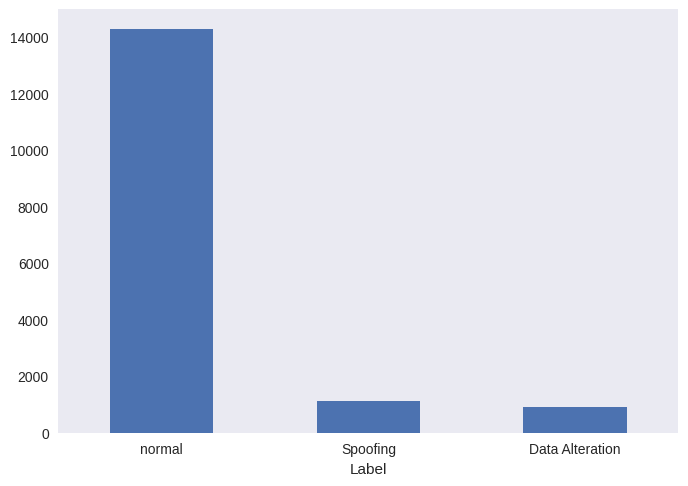

In [ ]:
data['Label'].value_counts().plot.bar(rot=360)
plt.grid()

# **Normalization**

In [ ]:
labelencoder = LabelEncoder()
data['Label'] = labelencoder.fit_transform(data['Label'])

In [ ]:
y=data['Label']
label = y.value_counts()
label

Label
2    14272
1     1124
0      922
Name: count, dtype: int64

In [ ]:
cols_numeric = data._get_numeric_data().columns
cols_numeric = list(cols_numeric)

scaler = sklearn.preprocessing.StandardScaler()
scaled = scaler.fit_transform(data[cols_numeric])

scaled_data = pd.DataFrame(scaled, columns=cols_numeric)
normalized_data = pd.concat([data.drop(cols_numeric, axis=1), scaled_data, ], axis=1)

data = normalized_data

data.head()

,SrcBytes,DstBytes,SrcLoad,DstLoad,SrcGap,DstGap,SIntPkt,DIntPkt,SIntPktAct,DIntPktAct,...,Rate,Temp,SpO2,Pulse_Rate,SYS,DIA,Heart_rate,Resp_Rate,ST,Label
0,-0.022749,-0.057668,0.819281,0.469702,0.0,0.0,-0.072751,-0.125972,-0.020716,0.0,...,0.601184,2.167124,-65.370506,-10.323866,-16.818002,-13.076386,-11.415506,-2.688581,-2.481385,0.355473
1,-0.022749,-0.057668,0.241017,0.131783,0.0,0.0,-0.065714,-0.106926,-0.020716,0.0,...,0.171546,2.167124,-65.370506,-10.323866,-16.818002,-13.076386,0.386762,-0.367962,1.365618,0.355473
2,-0.022749,-0.057668,0.083464,0.039699,0.0,0.0,-0.063284,-0.099441,-0.020716,0.0,...,0.054487,2.167124,-5.887398,3.670265,-16.818002,-13.076386,0.386762,-0.367962,1.365618,0.355473
3,-0.022749,-0.057668,-0.106571,-0.071344,0.0,0.0,-0.059955,-0.098726,-0.020716,0.0,...,-0.086707,2.167124,-5.887398,3.670265,-16.818002,-13.076386,0.538073,-0.367962,1.365618,0.355473
4,-0.022749,-0.057668,0.300682,0.166634,0.0,0.0,-0.066567,-0.107650,-0.020716,0.0,...,0.215869,2.167124,-5.887398,3.266588,-16.818002,-13.076386,0.538073,-0.367962,1.365618,0.355473


# **Feature Selection and Spliting**

In [ ]:
X = data.drop('Label', axis=1)

kbest = sklearn.feature_selection.SelectKBest(score_func=sklearn.feature_selection.mutual_info_classif, k=20)
kbest.fit(X, y)

X_kbest = kbest.transform(X)

kbest_indices = kbest.get_support(indices=True)SS

print(kbest_indices)

selected_features = X.columns[kbest_indices]
selected_data = data[selected_features]

data_best = pd.concat([selected_data, y], axis=1)

data_best.head()

[ 1  2  3  6  7  9 10 11 16 19 20 25 26 27 28 29 30 31 32 33]


,DstBytes,SrcLoad,DstLoad,SIntPkt,DIntPkt,DIntPktAct,SrcJitter,DstJitter,Dur,TotBytes,...,Rate,Temp,SpO2,Pulse_Rate,SYS,DIA,Heart_rate,Resp_Rate,ST,Label
0,-0.057668,0.819281,0.469702,-0.072751,-0.125972,0.0,-0.022964,-0.139398,-0.113968,-0.041308,...,0.601184,2.167124,-65.370506,-10.323866,-16.818002,-13.076386,-11.415506,-2.688581,-2.481385,2
1,-0.057668,0.241017,0.131783,-0.065714,-0.106926,0.0,-0.022849,-0.114451,-0.105416,-0.041308,...,0.171546,2.167124,-65.370506,-10.323866,-16.818002,-13.076386,0.386762,-0.367962,1.365618,2
2,-0.057668,0.083464,0.039699,-0.063284,-0.099441,0.0,-0.023040,-0.108350,-0.102463,-0.041308,...,0.054487,2.167124,-5.887398,3.670265,-16.818002,-13.076386,0.386762,-0.367962,1.365618,2
3,-0.057668,-0.106571,-0.071344,-0.059955,-0.098726,0.0,-0.023354,-0.106508,-0.098417,-0.041308,...,-0.086707,2.167124,-5.887398,3.670265,-16.818002,-13.076386,0.538073,-0.367962,1.365618,2
4,-0.057668,0.300682,0.166634,-0.066567,-0.107650,0.0,-0.022904,-0.115256,-0.106453,-0.041308,...,0.215869,2.167124,-5.887398,3.266588,-16.818002,-13.076386,0.538073,-0.367962,1.365618,2


In [ ]:
X = data_best.drop(columns=['Label'])

x_train, x_test, y_train, y_test = sklearn.model_selection.train_test_split(X,y, test_size=0.5)
print("Training set:", len(x_train))
print("Testing set:", len(x_test))

Training set: 8159
Testing set: 8159


In [ ]:
x_train.shape

(13054, 20)

In [ ]:
x_test.shape

(3264, 20)

# **Model Training** *scenario 1* done

Keterangan:

*   Dengan split train and test 8:2



In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score
from sklearn.ensemble import StackingClassifier, VotingClassifier, RandomForestClassifier, ExtraTreesClassifier, BaggingClassifier
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import BernoulliNB
from sklearn.neural_network import MLPClassifier
import time
import pickle

models = {}

estimators = [
    ('KNN', KNeighborsClassifier(n_jobs=-1)),
    ('SVC', SVC(probability=True)),
    ('xgb', XGBClassifier()),
    ('NBB', BernoulliNB()),
]

models['Stacking'] = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression(max_iter=50))
models['Voting'] = VotingClassifier(estimators=estimators, voting='soft')  # Ubah voting='hard' ke voting='soft'
models['Bagging'] = BaggingClassifier(base_estimator=RandomForestClassifier())
models['XGboost'] = XGBClassifier()
models['RandomForest'] = RandomForestClassifier()
models['ExtraTree'] = ExtraTreesClassifier()
models['DecisionTree'] = DecisionTreeClassifier()
models['KNeighborsClassifier'] = KNeighborsClassifier()

train_score, accuracy, precision, recall, f1, rocauc, training_time, y_pred, predict_time = {}, {}, {}, {}, {}, {}, {}, {}, {}

for key in models.keys():
    start_time_t = time.time()
    models[key].fit(x_train, y_train)
    training_time[key] = time.time() - start_time_t

    trained_model_name = f'/content/drive/MyDrive/Abc/trained8/{key}.pkl'
    with open(trained_model_name, 'wb') as file:
        pickle.dump(models[key], file)

    start_time_p = time.time()
    y_pred[key] = models[key].predict(x_test)
    predict_time[key] = time.time() - start_time_p

    train_score[key] = models[key].score(x_train, y_train)
    accuracy[key] = models[key].score(x_test, y_test)
    precision[key] = precision_score(y_test, y_pred[key], average='weighted')
    recall[key] = recall_score(y_test, y_pred[key], average='weighted')
    # rocauc[key] = sklearn.metrics.roc_auc_score(y_test, y_pred[key])
    if key == 'Voting' or key == 'Stacking':
        rocauc[key] = roc_auc_score(y_test, models[key].predict_proba(x_test), multi_class='ovo')
    else:
        rocauc[key] = roc_auc_score(y_test, models[key].predict_proba(x_test), multi_class='ovr')

    f1[key] = f1_score(y_test, y_pred[key], average='weighted')

print("Train Score:", train_score)
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("ROC AUC:", rocauc)
print("Training Time:", training_time)
print("Predict Time:", predict_time)


Train Score: {'Stacking': 0.9810019917266738, 'Voting': 0.9431591849241612, 'Bagging': 0.9687452121954956, 'XGboost': 0.9779377968438793, 'RandomForest': 1.0, 'ExtraTree': 1.0, 'DecisionTree': 1.0, 'KNeighborsClassifier': 0.9541136816301516}
Accuracy: {'Stacking': 0.9515931372549019, 'Voting': 0.9341299019607843, 'Bagging': 0.9319852941176471, 'XGboost': 0.9485294117647058, 'RandomForest': 0.9325980392156863, 'ExtraTree': 0.9319852941176471, 'DecisionTree': 0.8857230392156863, 'KNeighborsClassifier': 0.9387254901960784}
Precision: {'Stacking': 0.947006936758775, 'Voting': 0.9346713387938567, 'Bagging': 0.9219970703125, 'XGboost': 0.9449292315740525, 'RandomForest': 0.9153422176232509, 'ExtraTree': 0.9109570083049735, 'DecisionTree': 0.8959830178844325, 'KNeighborsClassifier': 0.9275214235331581}
Recall: {'Stacking': 0.9515931372549019, 'Voting': 0.9341299019607843, 'Bagging': 0.9319852941176471, 'XGboost': 0.9485294117647058, 'RandomForest': 0.9325980392156863, 'ExtraTree': 0.931985294

In [ ]:

res = pd.DataFrame(index=models.keys(), columns=['Training score', 'Accuracy', 'Precision', 'Recall', 'F1' ,'Training time', 'Predict Time'])
res['Training score'] = train_score.values()
res['Accuracy'] = accuracy.values()
res['Precision'] = precision.values()
res['Recall'] = recall.values()
res['ROC AUC'] = rocauc.values()
res['F1'] = f1.values()
res['Training time'] = training_time.values()
res['Predict Time'] = predict_time.values()
res = res.round(4)
res

,Training score,Accuracy,Precision,Recall,F1,Training time,Predict Time,ROC AUC
Stacking,0.9792,0.9470,0.9395,0.9470,0.9388,120.5317,0.8665,0.9687
Voting,0.9424,0.9366,0.9405,0.9366,0.9121,25.0903,1.4139,0.9560
Bagging,0.9700,0.9344,0.9231,0.9344,0.9075,24.7263,0.7768,0.8914
XGboost,0.9766,0.9467,0.9403,0.9467,0.9355,0.8367,0.0196,0.9544
RandomForest,1.0000,0.9317,0.9075,0.9317,0.9090,3.5258,0.0703,0.8825
ExtraTree,1.0000,0.9286,0.9006,0.9286,0.9069,1.2471,0.0988,0.8912
DecisionTree,1.0000,0.9007,0.8998,0.9007,0.9002,0.2536,0.0026,0.7844
KNeighborsClassifier,0.9553,0.9363,0.9241,0.9363,0.9260,0.0046,0.3758,0.8913


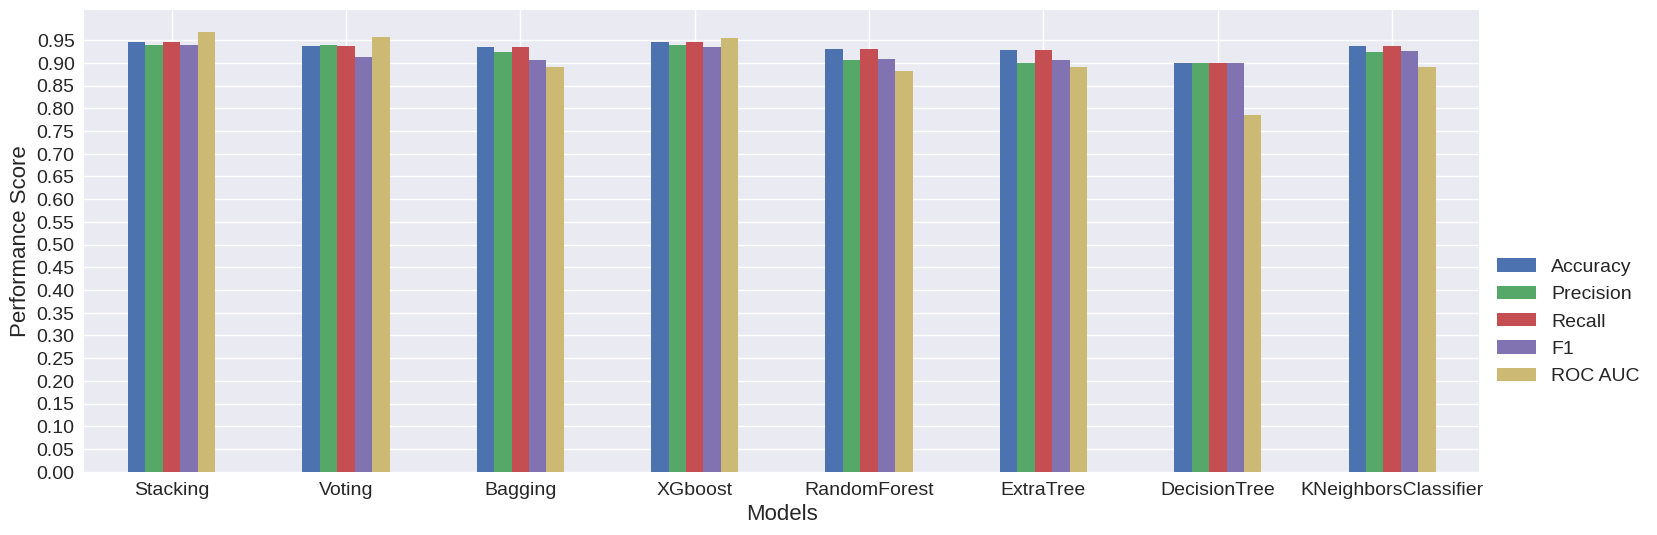

In [ ]:
res[["Accuracy","Precision","Recall","F1", "ROC AUC"]].plot.bar(figsize=(18,6))
# plt.title("Model Performance Comparison", size=20)
plt.xlabel("Models",size=16)
plt.ylabel("Performance Score",size=16)
plt.xticks(size=14,rotation = 0)
plt.yticks(np.arange(0,1,0.05),size=14)
plt.legend(loc='upper left', bbox_to_anchor=(1, 0.5),
          fancybox=True, shadow=True, fontsize=14)

# plt.savefig('ensemble_performance.png', dpi=300, bbox_inches='tight')
plt.show()

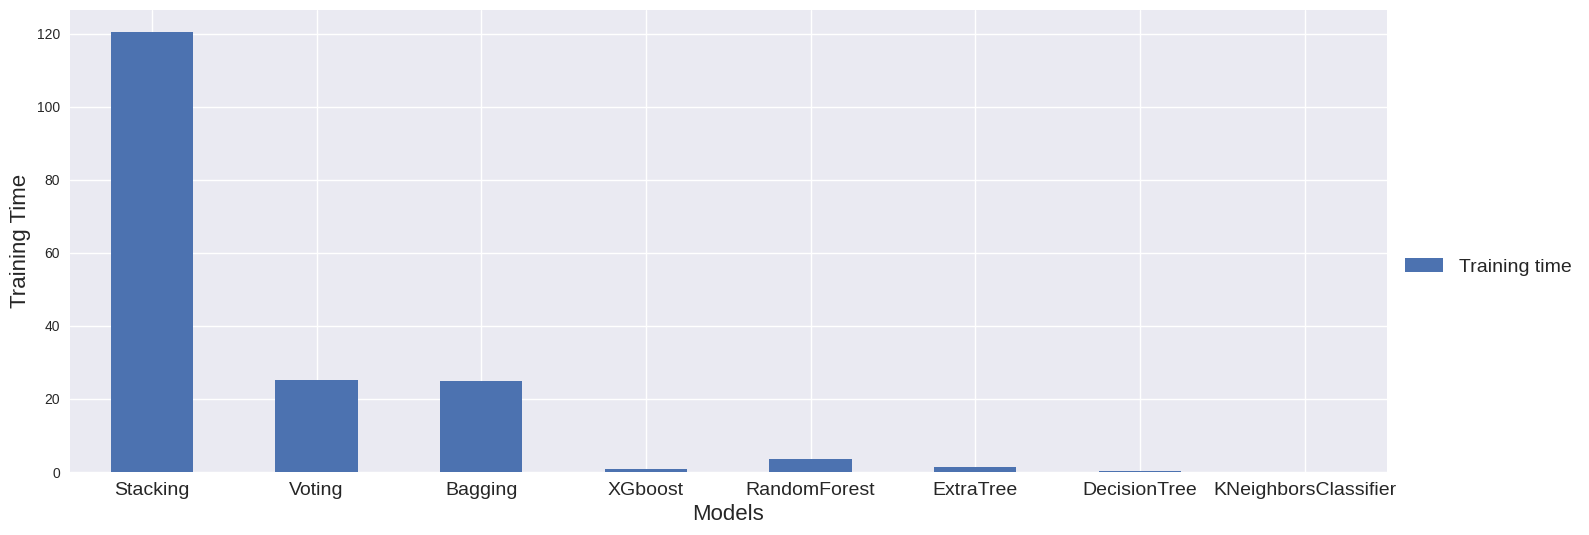

In [ ]:
res[["Training time"]].plot.bar(figsize=(17,6))
# plt.title("Model Performance Comparison", size=20)

plt.xlabel("Models",size=16)
plt.ylabel("Training Time",size=16)
plt.xticks(size=14,rotation = 0)
# plt.yticks(np.arange(0,100 + 0.5,0,5),size=14)
plt.legend(loc='upper left', bbox_to_anchor=(1, 0.5),
          fancybox=True, shadow=True, fontsize=14)

# plt.savefig('ensemble_performance.png', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Initialize dictionaries
fpr, fdr, false_positive, false_negative = {}, {}, {}, {}

for key in models.keys():
    # Compute confusion matrix
    cm = confusion_matrix(y_test, y_pred[key])

    # # Plot confusion matrix
    # disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y_test))
    # disp.plot(cmap='Blues')
    # plt.title(key)
    # plt.show()

    # Calculate false positives, false negatives, FPR, and FDR for each class
    fp = cm.sum(axis=0) - np.diag(cm)
    fn = cm.sum(axis=1) - np.diag(cm)
    tp = np.diag(cm)
    tn = cm.sum() - (fp + fn + tp)

    false_positive[key] = fp
    false_negative[key] = fn
    fpr[key] = fp / (fp + tn) * 100
    fdr[key] = fp / (fp + tp) * 100

    print(f"{key} False Positives: {fp}")
    print(f"{key} False Negatives: {fn}")
    print(f"{key} FPR: {fpr[key]}")
    print(f"{key} FDR: {fdr[key]}")
    print("=============")

Stacking False Positives: [  0  30 143]
Stacking False Negatives: [  3 140  30]
Stacking FPR: [ 0.          0.98554534 36.8556701 ]
Stacking FDR: [ 0.         27.27272727  4.78420877]
Voting False Positives: [  6   0 201]
Voting False Negatives: [  1 200   6]
Voting FPR: [ 0.19379845  0.         51.80412371]
Voting FDR: [3.46820809 0.         6.54509932]
Bagging False Positives: [  0   4 210]
Bagging False Negatives: [  2 208   4]
Bagging FPR: [ 0.          0.13140604 54.12371134]
Bagging FDR: [ 0.        25.         6.8137573]
XGboost False Positives: [  0  17 157]
XGboost False Negatives: [  3 154  17]
XGboost FPR: [ 0.          0.55847569 40.46391753]
XGboost FDR: [ 0.         20.48192771  5.20557029]
RandomForest False Positives: [  1  19 203]
RandomForest False Negatives: [  2 201  20]
RandomForest FPR: [3.22997416e-02 6.24178712e-01 5.23195876e+01]
RandomForest FDR: [ 0.5988024  50.          6.63615561]
ExtraTree False Positives: [  1  28 204]
ExtraTree False Negatives: [  3 201 

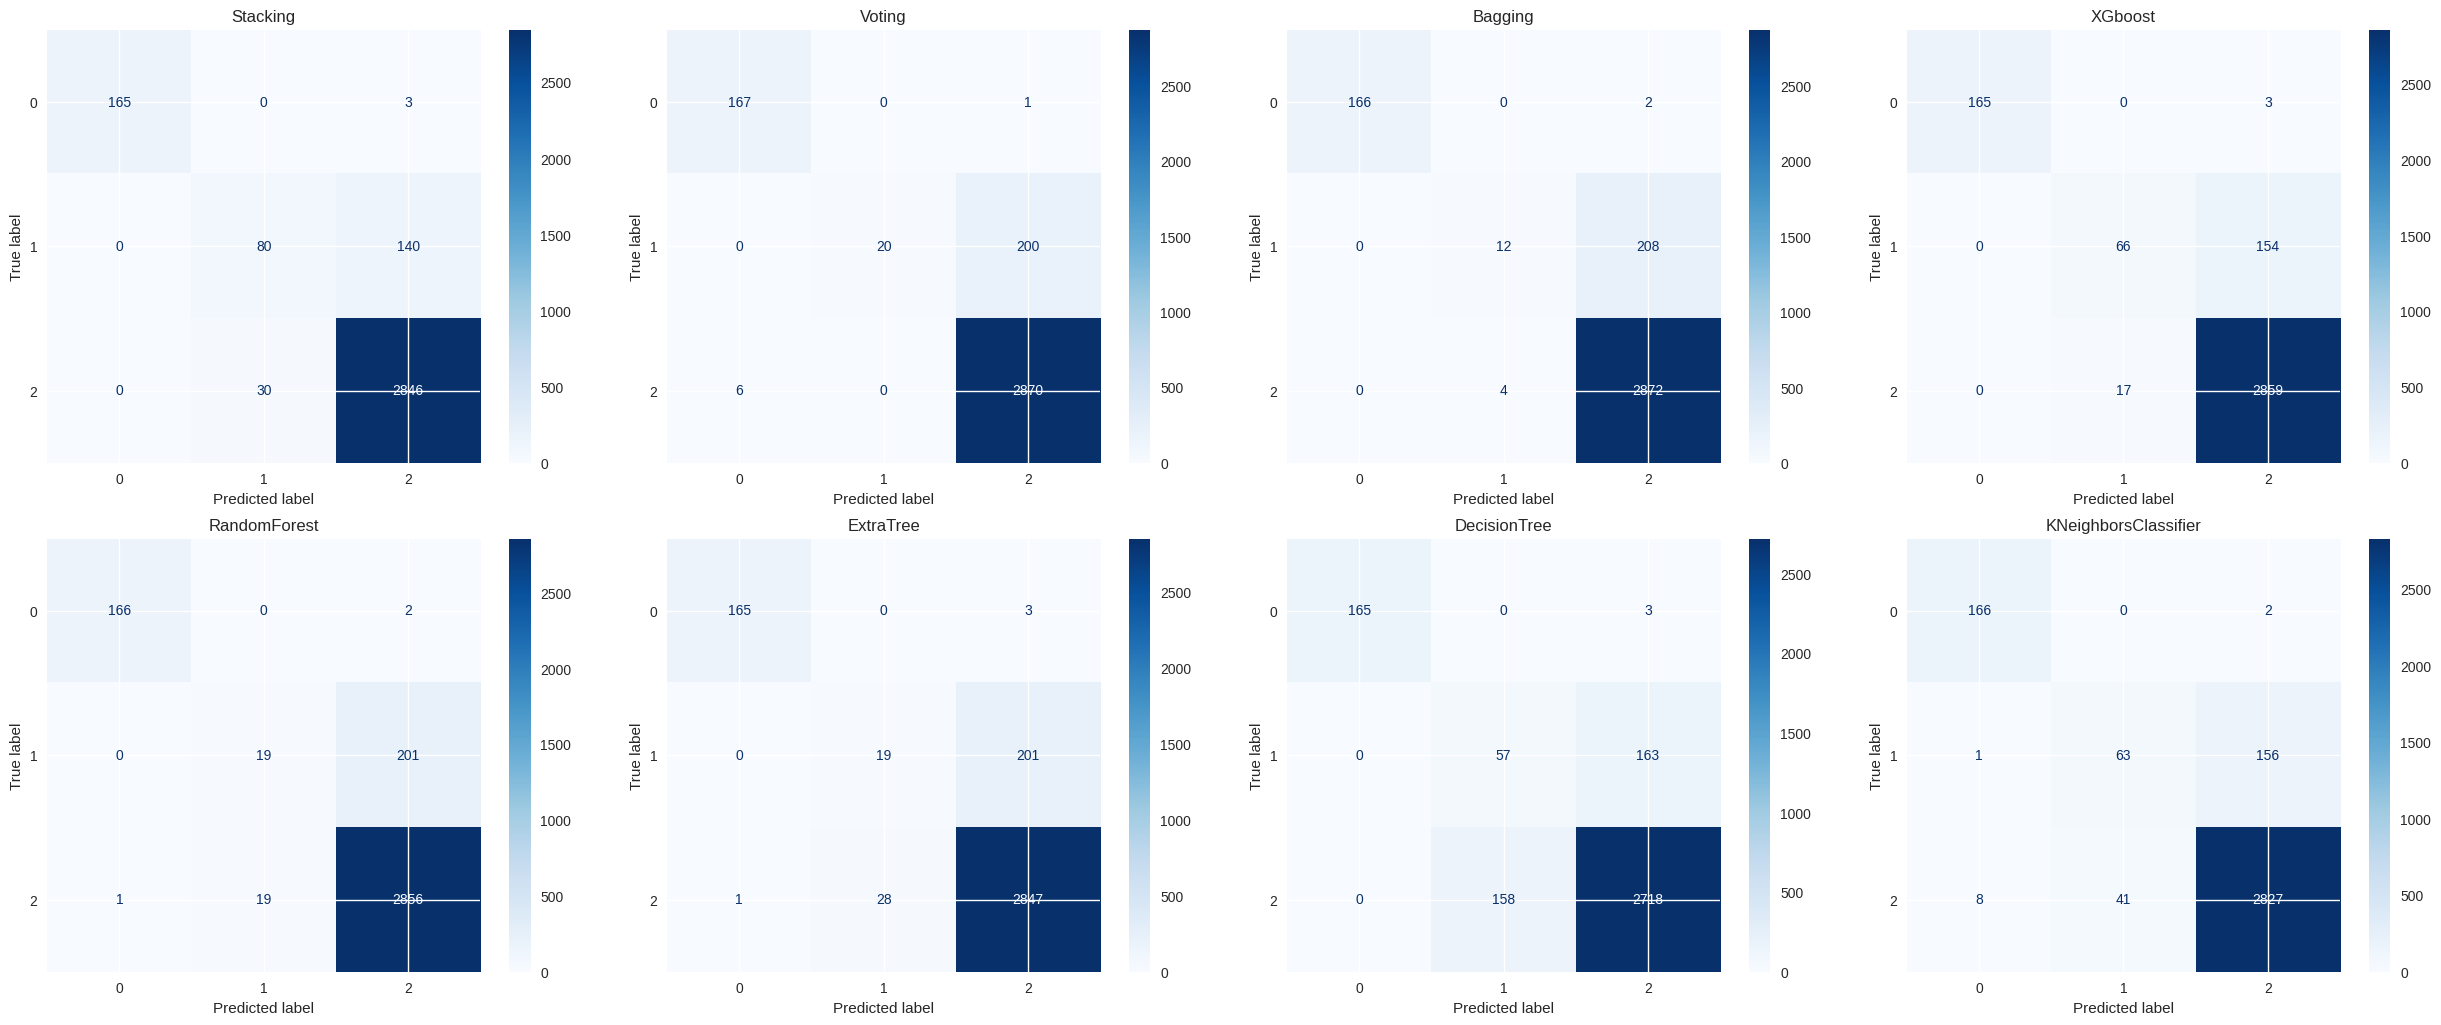

In [ ]:
import matplotlib.pyplot as plt
# import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cms = []

# Loop untuk menghitung confusion matrix untuk setiap model
for key in models.keys():
    # Compute confusion matrix
    cm = confusion_matrix(y_test, y_pred[key])
    cms.append((key, cm))

# Buat plot dengan subplots
num_models = len(models)
fig, axes = plt.subplots(nrows=3, ncols=(num_models + 1) // 2, figsize=(25, 15))
axes = axes.flatten()

# Plot each confusion matrix
for idx, (key, cm) in enumerate(cms):
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y_test))
    disp.plot(cmap='Blues', ax=axes[idx], colorbar=True)
    axes[idx].set_title(key)

# Remove any unused axes (if any)
for idx in range(num_models, len(axes)):
    fig.delaxes(axes[idx])

# Adjust layout
plt.tight_layout()
plt.show()


In [ ]:
print(fpr)

{'Stacking': array([ 0.        ,  0.98554534, 36.8556701 ]), 'Voting': array([ 0.19379845,  0.        , 51.80412371]), 'Bagging': array([ 0.        ,  0.13140604, 54.12371134]), 'XGboost': array([ 0.        ,  0.55847569, 40.46391753]), 'RandomForest': array([3.22997416e-02, 6.24178712e-01, 5.23195876e+01]), 'ExtraTree': array([3.22997416e-02, 9.19842313e-01, 5.25773196e+01]), 'DecisionTree': array([ 0.        ,  5.19053876, 42.78350515]), 'KNeighborsClassifier': array([ 0.29069767,  1.34691196, 40.72164948])}


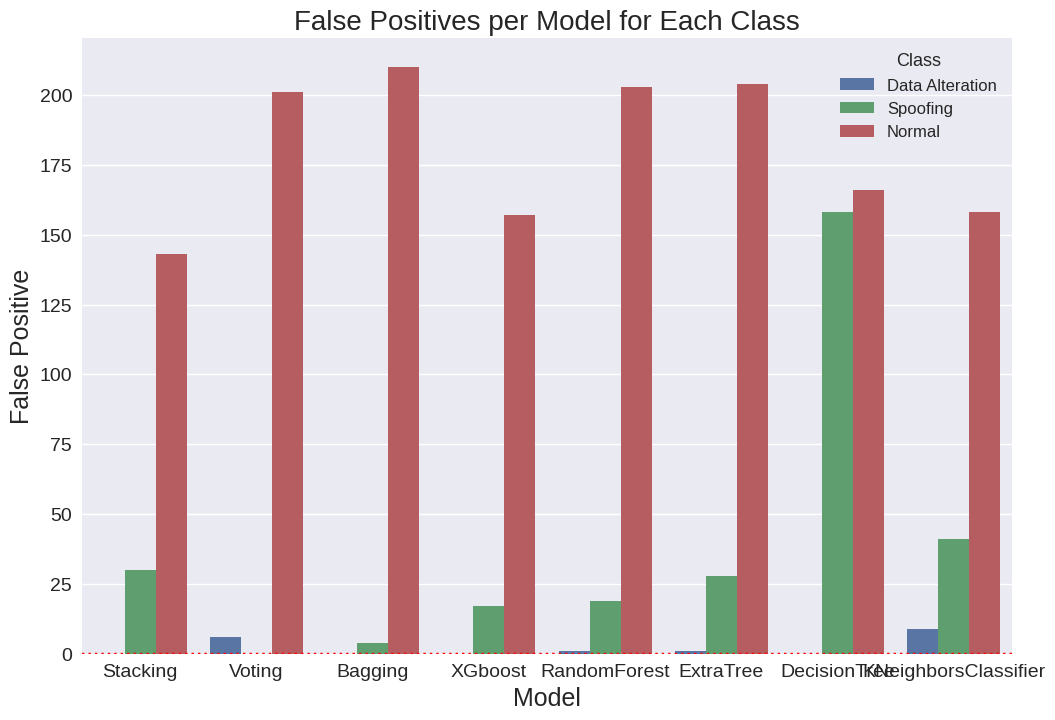

In [ ]:
# Extracting keys and values
models = list(false_positive.keys())
fp_values = np.array([false_positive[model] for model in models])
df_fp = pd.DataFrame(fp_values.T, columns=models)
df_fp['Class'] = ['Data Alteration', 'Spoofing', 'Normal']

# Melting the dataframe for seaborn
df_fp_melted = df_fp.melt(id_vars='Class', var_name='Model', value_name='False Positive')

# Plotting
plt.figure(figsize=(12, 8))
sns.barplot(x='Model', y='False Positive', hue='Class', data=df_fp_melted)
plt.xlabel('Model', size=18)
plt.ylabel('False Positive', size=18)
plt.xticks(size=14)
plt.yticks(size=14)
plt.axhline(color='r', linestyle=':')
plt.title('False Positives per Model for Each Class', size=20)
plt.legend(title='Class', title_fontsize='13', fontsize='12')
# plt.savefig('fp_performance.png', dpi=300, bbox_inches='tight')
plt.show()

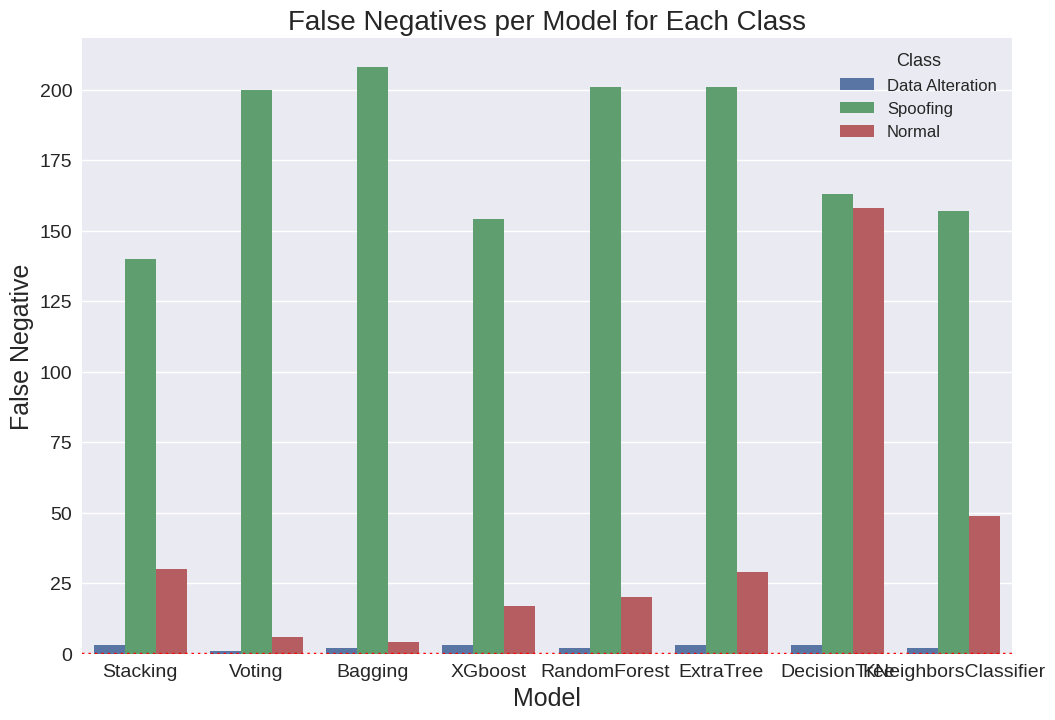

In [ ]:
# Extracting keys and values
models = list(false_negative.keys())
fp_values = np.array([false_negative[model] for model in models])
df_fp = pd.DataFrame(fp_values.T, columns=models)
df_fp['Class'] = ['Data Alteration', 'Spoofing', 'Normal']

# Melting the dataframe for seaborn
df_fp_melted = df_fp.melt(id_vars='Class', var_name='Model', value_name='False Negative')


plt.figure(figsize=(12, 8))
sns.barplot(x='Model', y='False Negative', hue='Class', data=df_fp_melted)
plt.xlabel('Model', size=18)
plt.ylabel('False Negative', size=18)
plt.xticks(size=14)
plt.yticks(size=14)
plt.axhline(color='r', linestyle=':')
plt.title('False Negatives per Model for Each Class', size=20)
plt.legend(title='Class', title_fontsize='13', fontsize='12')
# plt.savefig('fp_performance.png', dpi=300, bbox_inches='tight')
plt.show()

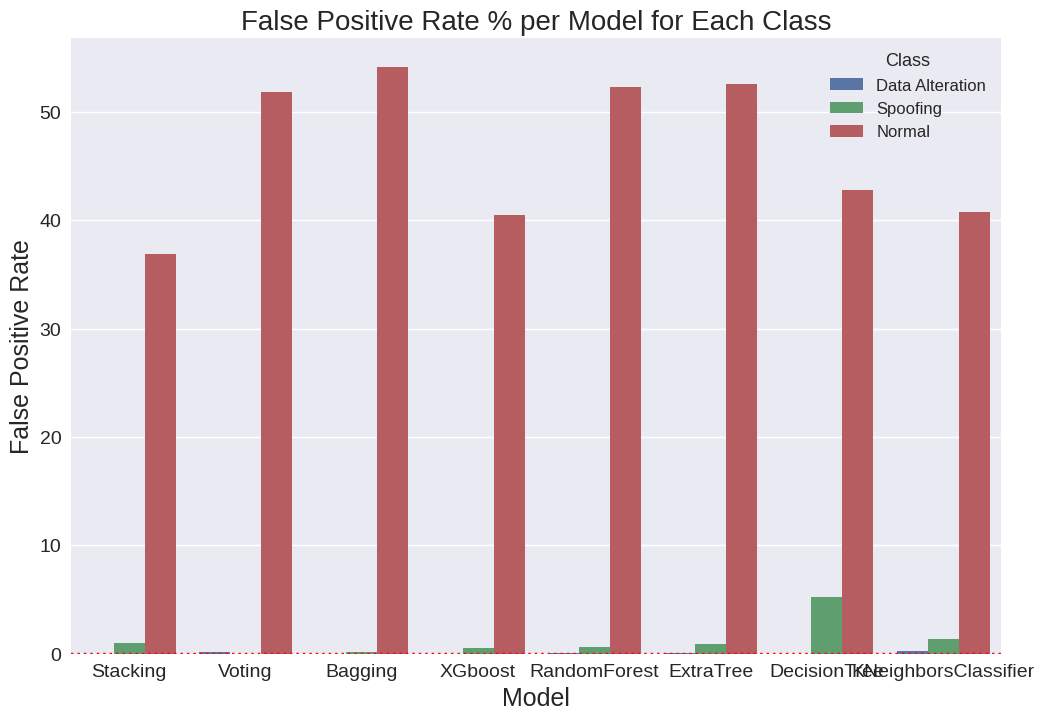

In [ ]:
# Extracting keys and values
models = list(fpr.keys())
fp_values = np.array([fpr[model] for model in models])
df_fp = pd.DataFrame(fp_values.T, columns=models)
df_fp['Class'] = ['Data Alteration', 'Spoofing', 'Normal']

# Melting the dataframe for seaborn
df_fp_melted = df_fp.melt(id_vars='Class', var_name='Model', value_name='False Positive Rate')


plt.figure(figsize=(12, 8))
sns.barplot(x='Model', y='False Positive Rate', hue='Class', data=df_fp_melted)
plt.xlabel('Model', size=18)
plt.ylabel('False Positive Rate', size=18)
plt.xticks(size=14)
plt.yticks(size=14)
plt.axhline(color='r', linestyle=':')
plt.title('False Positive Rate % per Model for Each Class', size=20)
plt.legend(title='Class', title_fontsize='13', fontsize='12')
# plt.savefig('fp_performance.png', dpi=300, bbox_inches='tight')
plt.show()

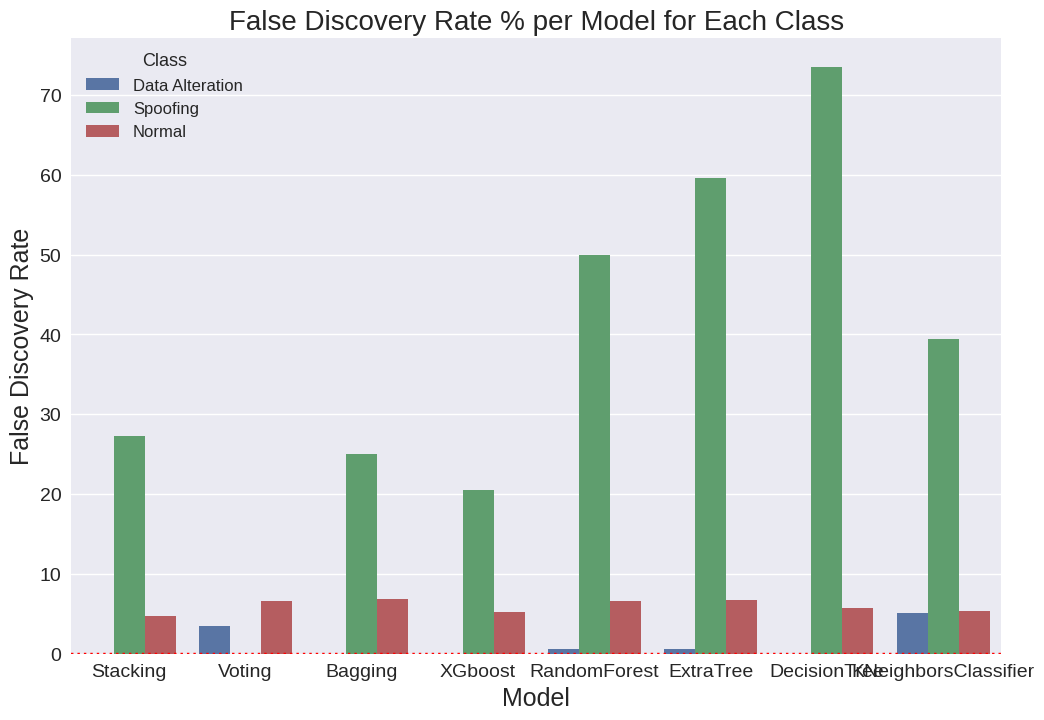

In [ ]:
# Extracting keys and values
models = list(fdr.keys())
fp_values = np.array([fdr[model] for model in models])
df_fp = pd.DataFrame(fp_values.T, columns=models)
df_fp['Class'] = ['Data Alteration', 'Spoofing', 'Normal']

# Melting the dataframe for seaborn
df_fp_melted = df_fp.melt(id_vars='Class', var_name='Model', value_name='False Discovery Rate')


plt.figure(figsize=(12, 8))
sns.barplot(x='Model', y='False Discovery Rate', hue='Class', data=df_fp_melted)
plt.xlabel('Model', size=18)
plt.ylabel('False Discovery Rate', size=18)
plt.xticks(size=14)
plt.yticks(size=14)
plt.axhline(color='r', linestyle=':')
plt.title('False Discovery Rate % per Model for Each Class', size=20)
plt.legend(title='Class', title_fontsize='13', fontsize='12')
# plt.savefig('fp_performance.png', dpi=300, bbox_inches='tight')
plt.show()

# **Model Training** *scenario 2*

Keterangan:

*   Dengan split train and test 7:3



In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score
from sklearn.ensemble import StackingClassifier, VotingClassifier, RandomForestClassifier, ExtraTreesClassifier, BaggingClassifier
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
# from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.svm import SVC
from sklearn.naive_bayes import BernoulliNB
from sklearn.neural_network import MLPClassifier
import time
import pickle

# Definisi model
models = {}

estimators = [
    ('KNN', KNeighborsClassifier(n_jobs=-1)),
    ('SVC', SVC(probability=True)),  # Tambahkan probability=True untuk SVC
    ('xgb', XGBClassifier()),
    ('NBB', BernoulliNB()),
    ('MLP', MLPClassifier(hidden_layer_sizes=(50,), max_iter=100, activation='relu', solver='adam', random_state=42))
]

models['Stacking'] = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression(max_iter=50))
models['Voting'] = VotingClassifier(estimators=estimators, voting='soft')  # Ubah voting='hard' ke voting='soft'
models['Bagging'] = BaggingClassifier(base_estimator=RandomForestClassifier())
models['XGboost'] = XGBClassifier()
models['RandomForest'] = RandomForestClassifier()
models['ExtraTree'] = ExtraTreesClassifier()
models['DecisionTree'] = DecisionTreeClassifier()
models['KNeighborsClassifier'] = KNeighborsClassifier()
# models['RidgeClassifier'] = RidgeClassifier(alpha=1.0, solver='auto')

# Inisialisasi metrik evaluasi
train_score, accuracy, precision, recall, f1, rocauc, training_time, y_pred, predict_time = {}, {}, {}, {}, {}, {}, {}, {}, {}

# Evaluasi setiap model
for key in models.keys():
    start_time_t = time.time()
    models[key].fit(x_train, y_train)
    training_time[key] = time.time() - start_time_t

    trained_model_name = f'/content/drive/MyDrive/Abc/trained7/{key}.pkl'
    with open(trained_model_name, 'wb') as file:
        pickle.dump(models[key], file)

    start_time_p = time.time()
    y_pred[key] = models[key].predict(x_test)
    predict_time[key] = time.time() - start_time_p

    train_score[key] = models[key].score(x_train, y_train)
    accuracy[key] = models[key].score(x_test, y_test)
    precision[key] = precision_score(y_test, y_pred[key], average='weighted')
    recall[key] = recall_score(y_test, y_pred[key], average='weighted')
    # rocauc[key] = sklearn.metrics.roc_auc_score(y_test, y_pred[key])
    if key == 'Voting' or key == 'Stacking':
        rocauc[key] = roc_auc_score(y_test, models[key].predict_proba(x_test), multi_class='ovo')
    else:
        rocauc[key] = roc_auc_score(y_test, models[key].predict_proba(x_test), multi_class='ovr')

    f1[key] = f1_score(y_test, y_pred[key], average='weighted')

# Output hasil evaluasi
print("Train Score:", train_score)
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("ROC AUC:", rocauc)
print("Training Time:", training_time)
print("Predict Time:", predict_time)


Train Score: {'Stacking': 0.9798634214673437, 'Voting': 0.9413412712309578, 'Bagging': 0.966205568201716, 'XGboost': 0.9769742601996148, 'RandomForest': 0.9999124496585536, 'ExtraTree': 1.0, 'DecisionTree': 1.0, 'KNeighborsClassifier': 0.9535983190334443}
Accuracy: {'Stacking': 0.9479166666666666, 'Voting': 0.9389297385620915, 'Bagging': 0.9334150326797386, 'XGboost': 0.9479166666666666, 'RandomForest': 0.9325980392156863, 'ExtraTree': 0.9307598039215687, 'DecisionTree': 0.8964460784313726, 'KNeighborsClassifier': 0.9383169934640523}
Precision: {'Stacking': 0.9406215534323005, 'Voting': 0.9385026473203733, 'Bagging': 0.9226802701378973, 'XGboost': 0.9411743812693233, 'RandomForest': 0.9122019736442014, 'ExtraTree': 0.9074854295142695, 'DecisionTree': 0.9038271298546865, 'KNeighborsClassifier': 0.9272398066153832}
Recall: {'Stacking': 0.9479166666666666, 'Voting': 0.9389297385620915, 'Bagging': 0.9334150326797386, 'XGboost': 0.9479166666666666, 'RandomForest': 0.9325980392156863, 'Extra

In [ ]:
res = pd.DataFrame(index=models.keys(), columns=['Training score', 'Accuracy', 'Precision', 'Recall', 'F1' ,'Training time', 'Predict Time'])
res['Training score'] = train_score.values()
res['Accuracy'] = accuracy.values()
res['Precision'] = precision.values()
res['Recall'] = recall.values()
res['ROC AUC'] = rocauc.values()
res['F1'] = f1.values()
res['Training time'] = training_time.values()
res['Predict Time'] = predict_time.values()
res = res.round(4)
res

,Training score,Accuracy,Precision,Recall,F1,Training time,Predict Time,ROC AUC
Stacking,0.9818,0.9506,0.9459,0.9506,0.9430,95.6868,1.0669,0.9706
Voting,0.9420,0.9324,0.9312,0.9324,0.9063,21.5315,1.1018,0.9576
Bagging,0.9683,0.9287,0.9178,0.9287,0.8973,23.0132,0.8908,0.8989
XGboost,0.9771,0.9467,0.9426,0.9467,0.9354,0.7888,0.0305,0.9602
RandomForest,1.0000,0.9310,0.9190,0.9310,0.9049,3.0791,0.0925,0.8964
ExtraTree,1.0000,0.9316,0.9167,0.9316,0.9088,1.1146,0.1287,0.8928
DecisionTree,1.0000,0.9071,0.9093,0.9071,0.9082,0.2903,0.0036,0.8219
KNeighborsClassifier,0.9541,0.9340,0.9223,0.9340,0.9248,0.0059,0.8846,0.8958


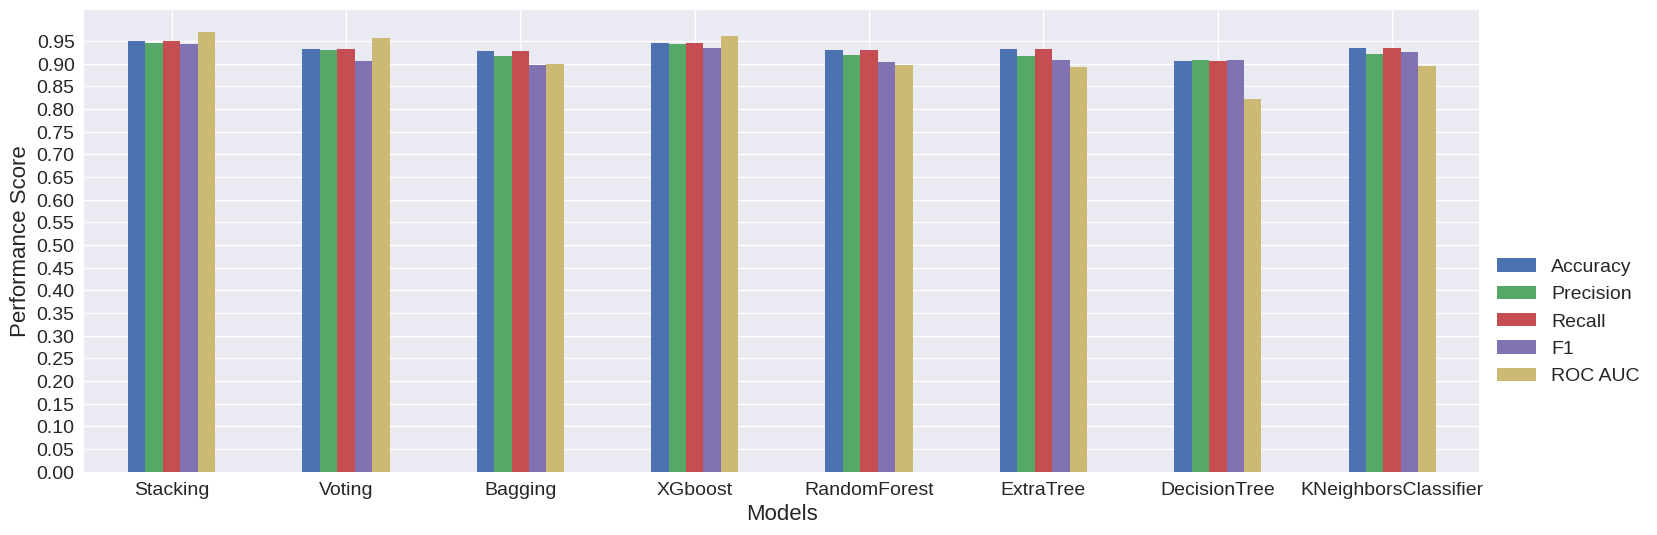

In [ ]:
res[["Accuracy","Precision","Recall","F1", "ROC AUC"]].plot.bar(figsize=(18,6))
# plt.title("Model Performance Comparison", size=20)
plt.xlabel("Models",size=16)
plt.ylabel("Performance Score",size=16)
plt.xticks(size=14,rotation = 0)
plt.yticks(np.arange(0,1,0.05),size=14)
plt.legend(loc='upper left', bbox_to_anchor=(1, 0.5),
          fancybox=True, shadow=True, fontsize=14)

# plt.savefig('ensemble_performance.png', dpi=300, bbox_inches='tight')
plt.show()

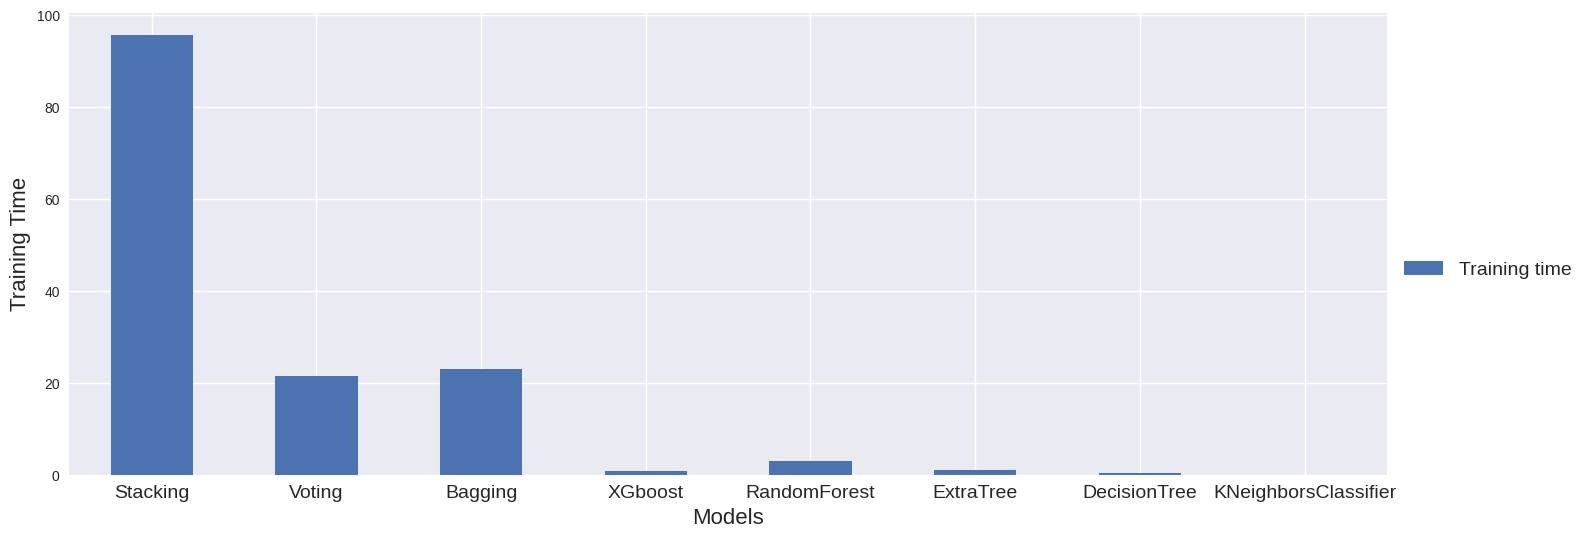

In [ ]:
res[["Training time"]].plot.bar(figsize=(17,6))
# plt.title("Model Performance Comparison", size=20)

plt.xlabel("Models",size=16)
plt.ylabel("Training Time",size=16)
plt.xticks(size=14,rotation = 0)
# plt.yticks(np.arange(0,100 + 0.5,0,5),size=14)
plt.legend(loc='upper left', bbox_to_anchor=(1, 0.5),
          fancybox=True, shadow=True, fontsize=14)

# plt.savefig('ensemble_performance.png', dpi=300, bbox_inches='tight')
plt.show()

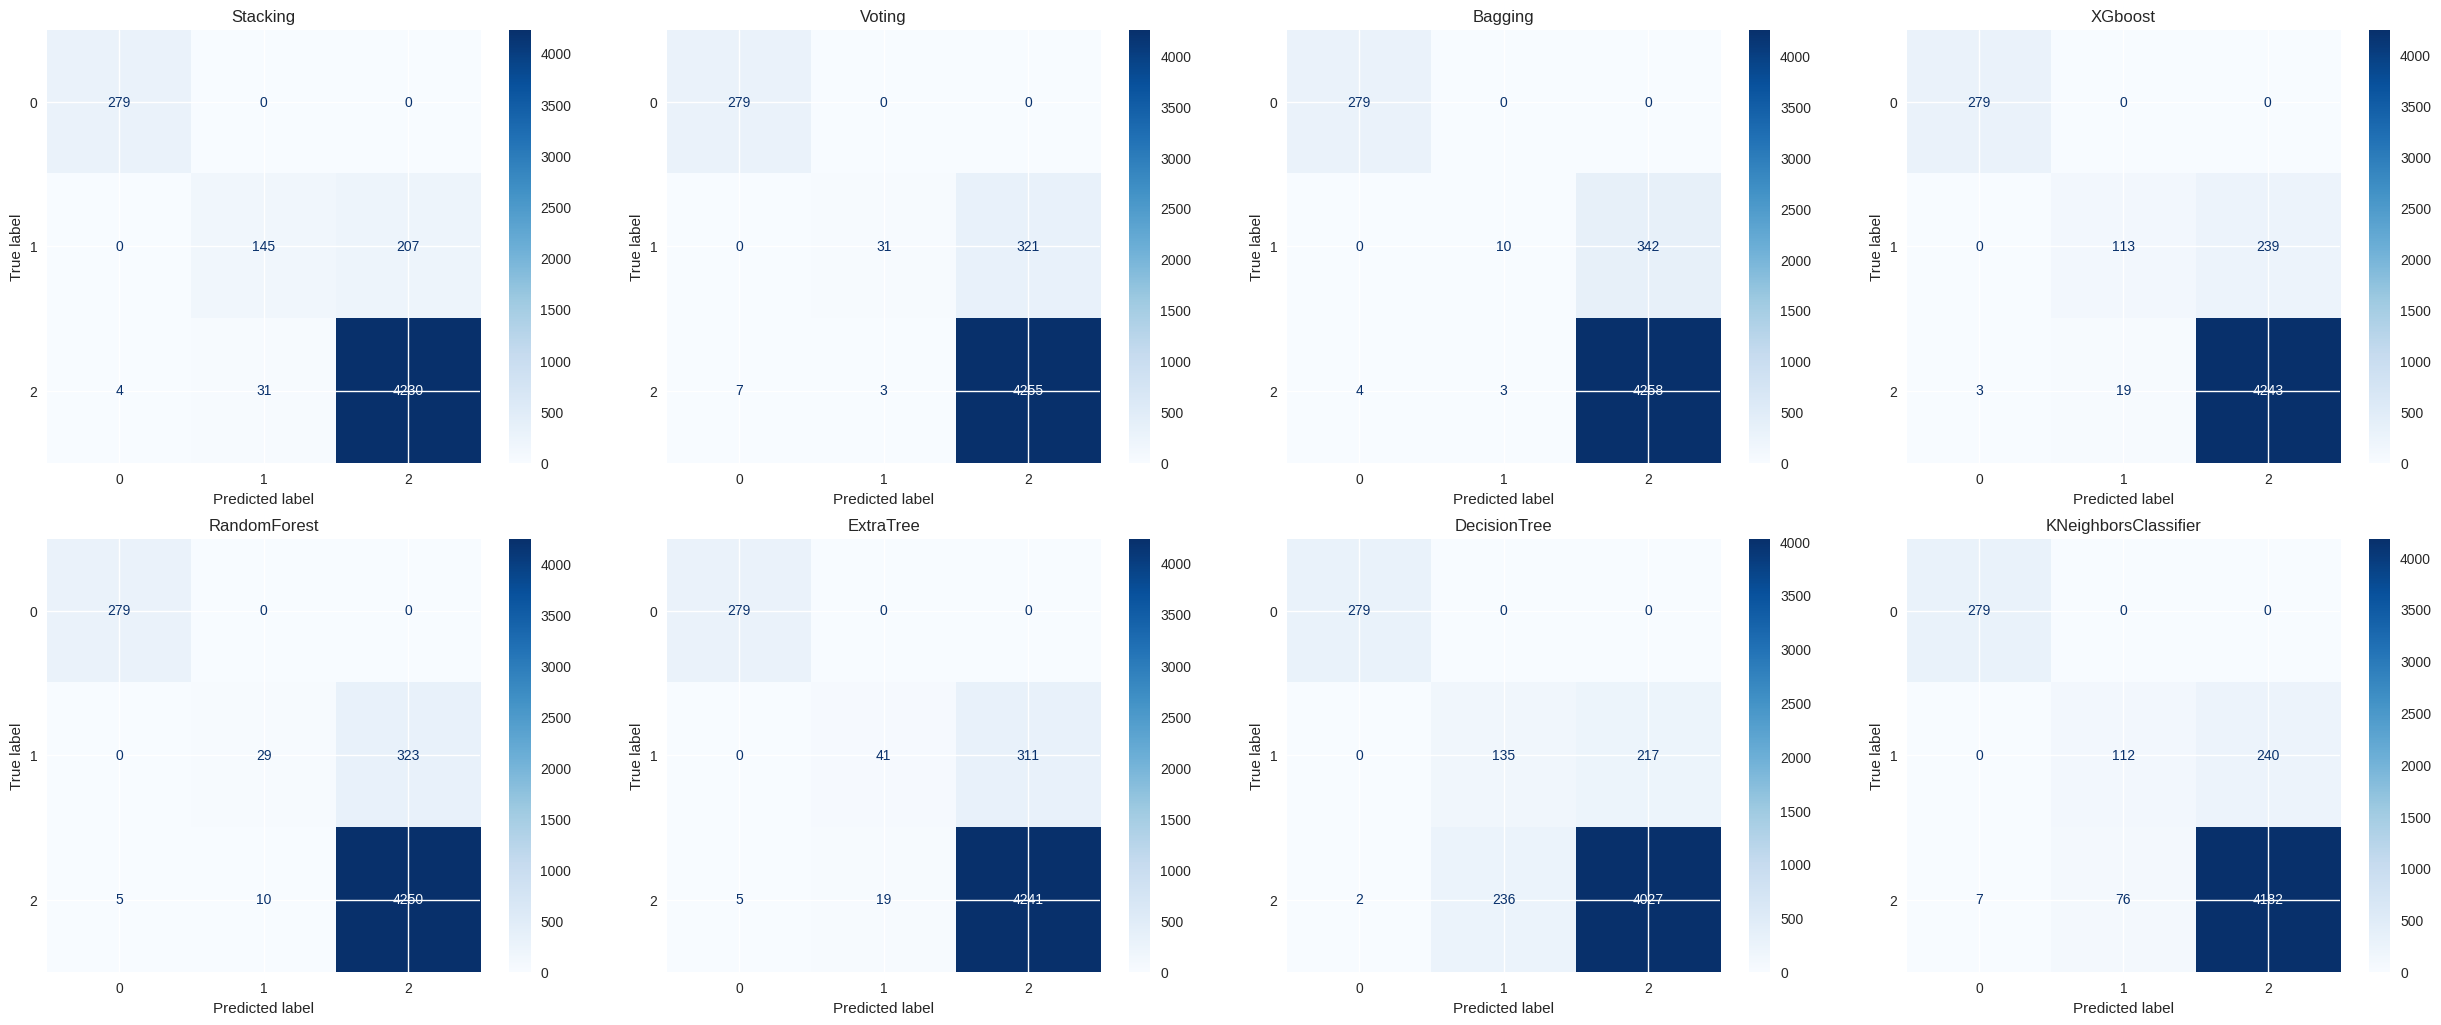

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Initialize dictionaries
# fpr, fdr, false_positive, false_negative = {}, {}, {}, {}

# List untuk menyimpan confusion matrix
cms = []

# Loop untuk menghitung confusion matrix untuk setiap model
for key in models.keys():
    # Compute confusion matrix
    cm = confusion_matrix(y_test, y_pred[key])
    cms.append((key, cm))

# Buat plot dengan subplots
num_models = len(models)
fig, axes = plt.subplots(nrows=3, ncols=(num_models + 1) // 2, figsize=(25, 15))

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Plot each confusion matrix
for idx, (key, cm) in enumerate(cms):
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y_test))
    disp.plot(cmap='Blues', ax=axes[idx], colorbar=True)
    axes[idx].set_title(key)

# Remove any unused axes (if any)
for idx in range(num_models, len(axes)):
    fig.delaxes(axes[idx])

# Adjust layout
plt.tight_layout()
plt.show()


In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Initialize dictionaries
fpr, fdr, false_positive, false_negative = {}, {}, {}, {}

for key in models.keys():
    # # Compute confusion matrix
    cm = confusion_matrix(y_test, y_pred[key])

    # # Plot confusion matrix
    # disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y_test))
    # disp.plot(cmap='Blues')
    # plt.title(key)
    # plt.show()

    # Calculate false positives, false negatives, FPR, and FDR for each class
    fp = cm.sum(axis=0) - np.diag(cm)
    fn = cm.sum(axis=1) - np.diag(cm)
    tp = np.diag(cm)
    tn = cm.sum() - (fp + fn + tp)

    false_positive[key] = fp
    false_negative[key] = fn
    fpr[key] = fp / (fp + tn) * 100
    fdr[key] = fp / (fp + tp) * 100

    print(f"{key} False Positives: {fp}")
    print(f"{key} False Negatives: {fn}")
    print(f"{key} FPR: {fpr[key]}")
    print(f"{key} FDR: {fdr[key]}")
    print("=============")

Stacking False Positives: [  4  31 207]
Stacking False Negatives: [  0 207  35]
Stacking FPR: [ 0.08663634  0.68221831 32.80507132]
Stacking FDR: [ 1.41342756 17.61363636  4.6653144 ]
Voting False Positives: [  7   3 321]
Voting False Negatives: [  0 321  10]
Voting FPR: [ 0.1516136   0.06602113 50.87163233]
Voting FDR: [2.44755245 8.82352941 7.01486014]
Bagging False Positives: [  4   3 342]
Bagging False Negatives: [  0 342   7]
Bagging FPR: [ 0.08663634  0.06602113 54.19968304]
Bagging FDR: [ 1.41342756 23.07692308  7.43478261]
XGboost False Positives: [  3  19 239]
XGboost False Negatives: [  0 239  22]
XGboost FPR: [ 0.06497726  0.4181338  37.87638669]
XGboost FDR: [ 1.06382979 14.39393939  5.33244087]
RandomForest False Positives: [  5  10 323]
RandomForest False Negatives: [  0 323  15]
RandomForest FPR: [ 0.10829543  0.22007042 51.18858954]
RandomForest FDR: [ 1.76056338 25.64102564  7.06319703]
ExtraTree False Positives: [  5  19 311]
ExtraTree False Negatives: [  0 311  24]
E

In [ ]:
print(fpr)

{'Stacking': array([ 0.08663634,  0.68221831, 32.80507132]), 'Voting': array([ 0.1516136 ,  0.06602113, 50.87163233]), 'Bagging': array([ 0.08663634,  0.06602113, 54.19968304]), 'XGboost': array([ 0.06497726,  0.4181338 , 37.87638669]), 'RandomForest': array([ 0.10829543,  0.22007042, 51.18858954]), 'ExtraTree': array([ 0.10829543,  0.4181338 , 49.28684628]), 'DecisionTree': array([ 0.04331817,  5.19366197, 34.38985737]), 'KNeighborsClassifier': array([ 0.1516136 ,  1.67253521, 38.03486529])}


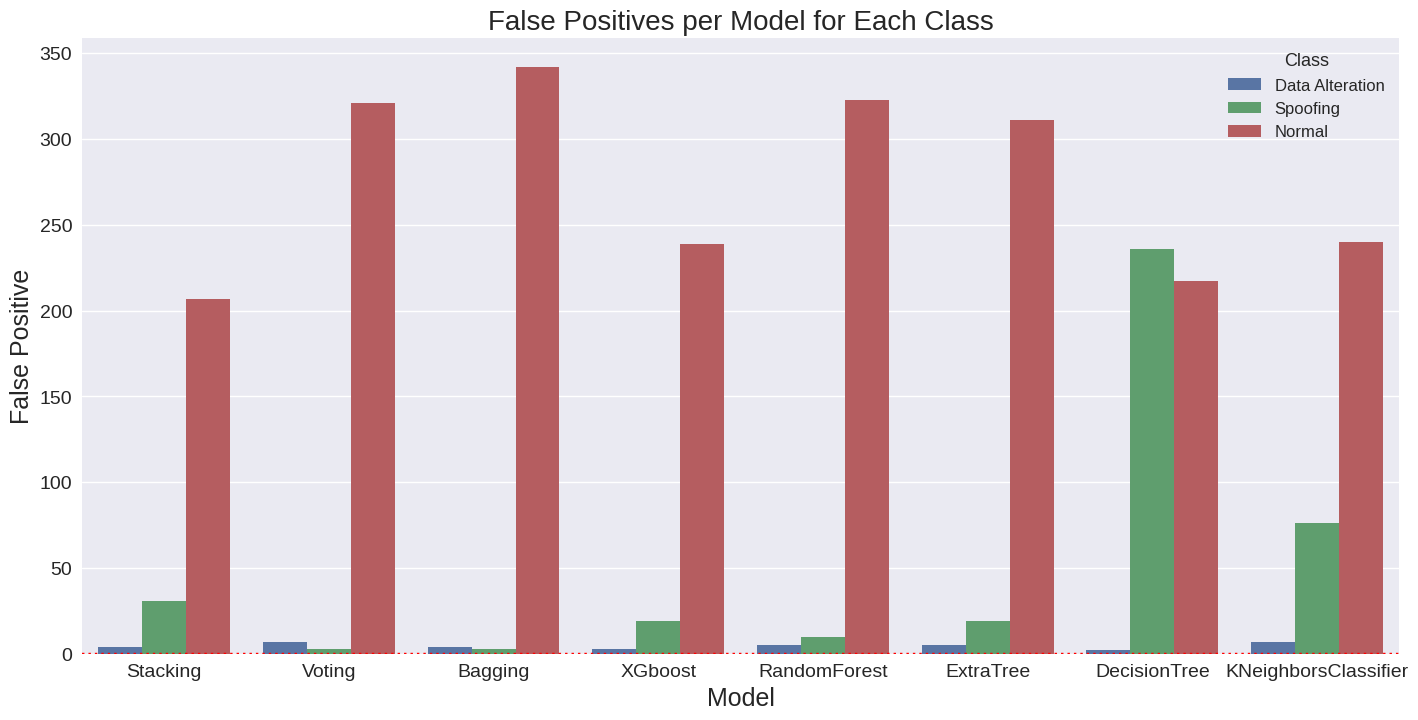

In [ ]:
# Extracting keys and values
false_p = list(false_positive.keys())
fp_values = np.array([false_positive[model] for model in false_p])
df_fp = pd.DataFrame(fp_values.T, columns=false_p)
df_fp['Class'] = ['Data Alteration', 'Spoofing', 'Normal']

# Melting the dataframe for seaborn
df_fp_melted = df_fp.melt(id_vars='Class', var_name='Model', value_name='False Positive')

# Plotting
plt.figure(figsize=(17, 8))
sns.barplot(x='Model', y='False Positive', hue='Class', data=df_fp_melted)
plt.xlabel('Model', size=18)
plt.ylabel('False Positive', size=18)
plt.xticks(size=14)
plt.yticks(size=14)
plt.axhline(color='r', linestyle=':')
plt.title('False Positives per Model for Each Class', size=20)
plt.legend(title='Class', title_fontsize='13', fontsize='12')
# plt.savefig('fp_performance.png', dpi=300, bbox_inches='tight')
plt.show()

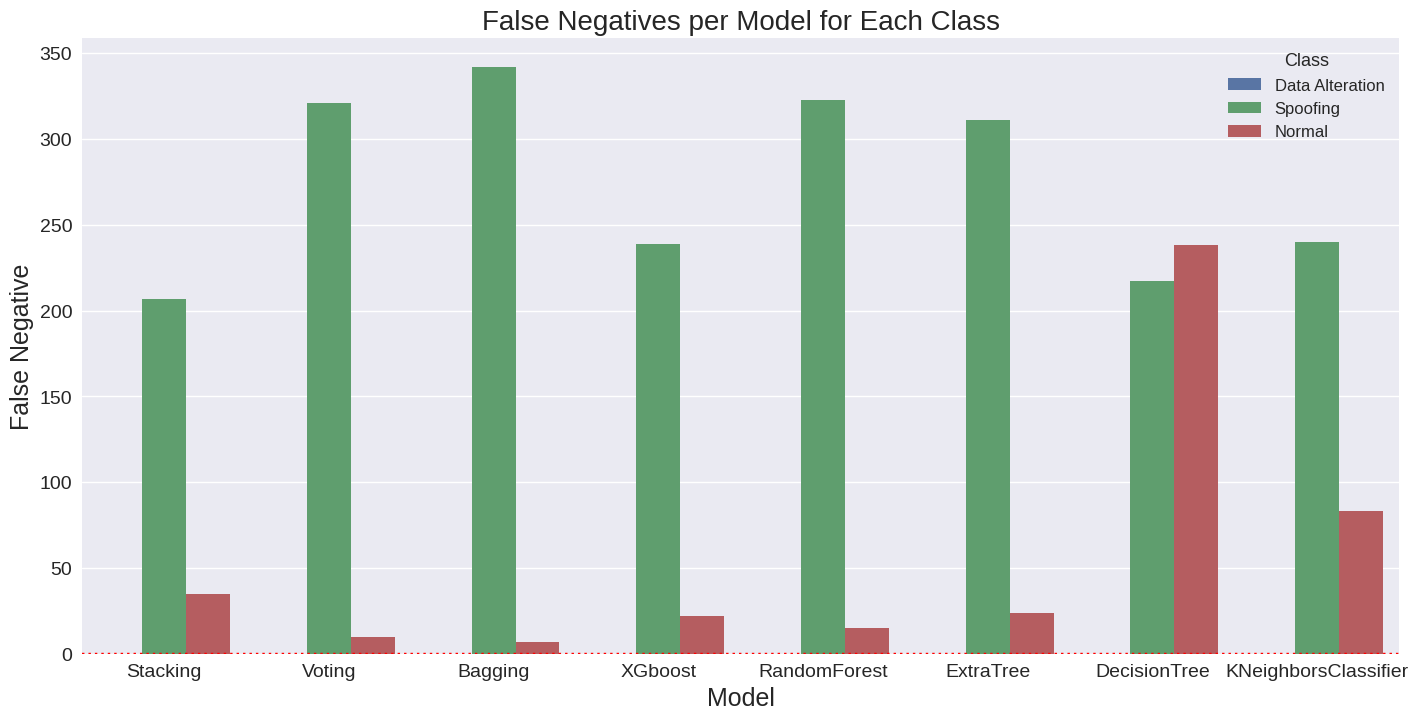

In [ ]:
# Extracting keys and values
false_n = list(false_negative.keys())
fp_values = np.array([false_negative[model] for model in false_n])
df_fp = pd.DataFrame(fp_values.T, columns=false_n)
df_fp['Class'] = ['Data Alteration', 'Spoofing', 'Normal']

# Melting the dataframe for seaborn
df_fp_melted = df_fp.melt(id_vars='Class', var_name='Model', value_name='False Negative')


plt.figure(figsize=(17, 8))
sns.barplot(x='Model', y='False Negative', hue='Class', data=df_fp_melted)
plt.xlabel('Model', size=18)
plt.ylabel('False Negative', size=18)
plt.xticks(size=14)
plt.yticks(size=14)
plt.axhline(color='r', linestyle=':')
plt.title('False Negatives per Model for Each Class', size=20)
plt.legend(title='Class', title_fontsize='13', fontsize='12')
# plt.savefig('fp_performance.png', dpi=300, bbox_inches='tight')
plt.show()

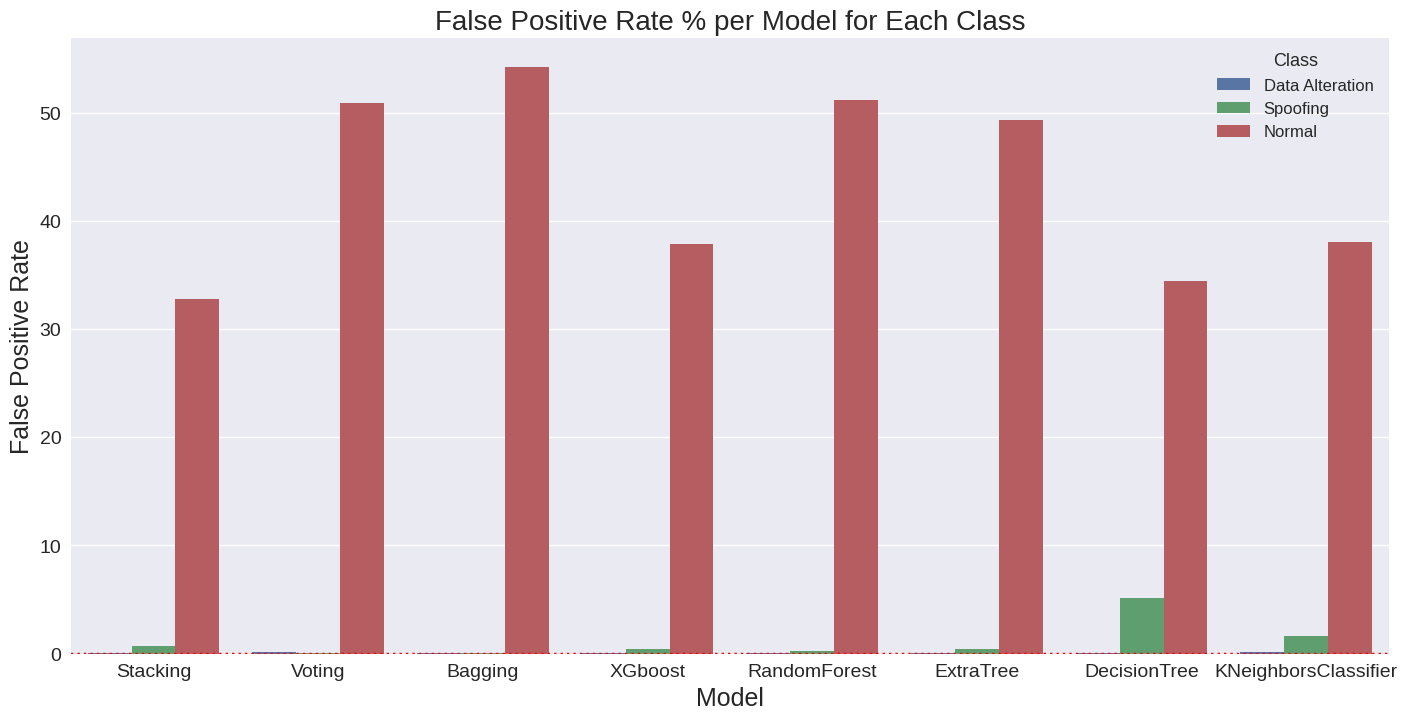

In [ ]:
# Extracting keys and values
false_pr = list(fpr.keys())
fp_values = np.array([fpr[model] for model in false_pr])
df_fp = pd.DataFrame(fp_values.T, columns=false_pr)
df_fp['Class'] = ['Data Alteration', 'Spoofing', 'Normal']

# Melting the dataframe for seaborn
df_fp_melted = df_fp.melt(id_vars='Class', var_name='Model', value_name='False Positive Rate')


plt.figure(figsize=(17, 8))
sns.barplot(x='Model', y='False Positive Rate', hue='Class', data=df_fp_melted)
plt.xlabel('Model', size=18)
plt.ylabel('False Positive Rate', size=18)
plt.xticks(size=14)
plt.yticks(size=14)
plt.axhline(color='r', linestyle=':')
plt.title('False Positive Rate % per Model for Each Class', size=20)
plt.legend(title='Class', title_fontsize='13', fontsize='12')
# plt.savefig('fp_performance.png', dpi=300, bbox_inches='tight')
plt.show()

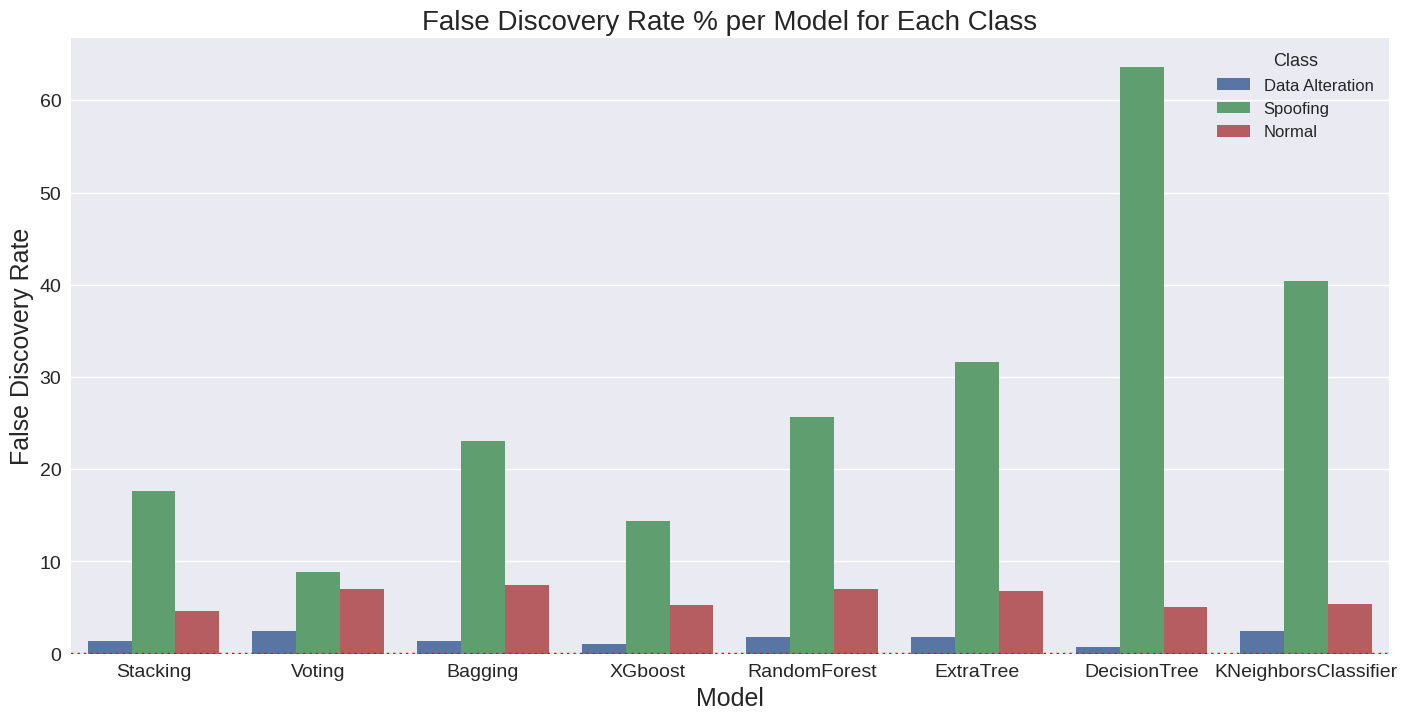

In [ ]:
# Extracting keys and values
false_dr = list(fdr.keys())
fp_values = np.array([fdr[model] for model in false_dr])
df_fp = pd.DataFrame(fp_values.T, columns=false_dr)
df_fp['Class'] = ['Data Alteration', 'Spoofing', 'Normal']

# Melting the dataframe for seaborn
df_fp_melted = df_fp.melt(id_vars='Class', var_name='Model', value_name='False Discovery Rate')


plt.figure(figsize=(17, 8))
sns.barplot(x='Model', y='False Discovery Rate', hue='Class', data=df_fp_melted)
plt.xlabel('Model', size=18)
plt.ylabel('False Discovery Rate', size=18)
plt.xticks(size=14)
plt.yticks(size=14)
plt.axhline(color='r', linestyle=':')
plt.title('False Discovery Rate % per Model for Each Class', size=20)
plt.legend(title='Class', title_fontsize='13', fontsize='12')
# plt.savefig('fp_performance.png', dpi=300, bbox_inches='tight')
plt.show()

# **Model Training** *scenario 3*

Keterangan:

*   Dengan split train and test 6:4



In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score
from sklearn.ensemble import StackingClassifier, VotingClassifier, RandomForestClassifier, ExtraTreesClassifier, BaggingClassifier
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
# from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.svm import SVC
from sklearn.naive_bayes import BernoulliNB
from sklearn.neural_network import MLPClassifier
import time
import pickle

# Definisi model
models = {}

estimators = [
    ('KNN', KNeighborsClassifier(n_jobs=-1)),
    ('SVC', SVC(probability=True)),  # Tambahkan probability=True untuk SVC
    ('xgb', XGBClassifier()),
    ('NBB', BernoulliNB()),
    ('MLP', MLPClassifier(hidden_layer_sizes=(50,), max_iter=100, activation='relu', solver='adam', random_state=42))
]

models['Stacking'] = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression(max_iter=50))
models['Voting'] = VotingClassifier(estimators=estimators, voting='soft')  # Ubah voting='hard' ke voting='soft'
models['Bagging'] = BaggingClassifier(base_estimator=RandomForestClassifier())
models['XGboost'] = XGBClassifier()
models['RandomForest'] = RandomForestClassifier()
models['ExtraTree'] = ExtraTreesClassifier()
models['DecisionTree'] = DecisionTreeClassifier()
models['KNeighborsClassifier'] = KNeighborsClassifier()
# models['RidgeClassifier'] = RidgeClassifier(alpha=1.0, solver='auto')

# Inisialisasi metrik evaluasi
train_score, accuracy, precision, recall, f1, rocauc, training_time, y_pred, predict_time = {}, {}, {}, {}, {}, {}, {}, {}, {}

# Evaluasi setiap model
for key in models.keys():
    start_time_t = time.time()
    models[key].fit(x_train, y_train)
    training_time[key] = time.time() - start_time_t

    trained_model_name = f'/content/drive/MyDrive/Abc/trained6/{key}.pkl'
    with open(trained_model_name, 'wb') as file:
        pickle.dump(models[key], file)

    start_time_p = time.time()
    y_pred[key] = models[key].predict(x_test)
    predict_time[key] = time.time() - start_time_p

    train_score[key] = models[key].score(x_train, y_train)
    accuracy[key] = models[key].score(x_test, y_test)
    precision[key] = precision_score(y_test, y_pred[key], average='weighted')
    recall[key] = recall_score(y_test, y_pred[key], average='weighted')
    # rocauc[key] = sklearn.metrics.roc_auc_score(y_test, y_pred[key])
    if key == 'Voting' or key == 'Stacking':
        rocauc[key] = roc_auc_score(y_test, models[key].predict_proba(x_test), multi_class='ovo')
    else:
        rocauc[key] = roc_auc_score(y_test, models[key].predict_proba(x_test), multi_class='ovr')

    f1[key] = f1_score(y_test, y_pred[key], average='weighted')

# Output hasil evaluasi
print("Train Score:", train_score)
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("ROC AUC:", rocauc)
print("Training Time:", training_time)
print("Predict Time:", predict_time)


Train Score: {'Stacking': 0.9831460674157303, 'Voting': 0.9390194075587334, 'Bagging': 0.9665985699693564, 'XGboost': 0.9806945863125638, 'RandomForest': 1.0, 'ExtraTree': 1.0, 'DecisionTree': 1.0, 'KNeighborsClassifier': 0.9529111338100102}
Accuracy: {'Stacking': 0.9514399509803921, 'Voting': 0.9352022058823529, 'Bagging': 0.9327512254901961, 'XGboost': 0.9508272058823529, 'RandomForest': 0.9342830882352942, 'ExtraTree': 0.9333639705882353, 'DecisionTree': 0.9053308823529411, 'KNeighborsClassifier': 0.9365808823529411}
Precision: {'Stacking': 0.9463798723817275, 'Voting': 0.9338322957416453, 'Bagging': 0.9158375787310156, 'XGboost': 0.9481954551980346, 'RandomForest': 0.9165901964613432, 'ExtraTree': 0.9135733359978144, 'DecisionTree': 0.9125149315078821, 'KNeighborsClassifier': 0.9237887105659259}
Recall: {'Stacking': 0.9514399509803921, 'Voting': 0.9352022058823529, 'Bagging': 0.9327512254901961, 'XGboost': 0.9508272058823529, 'RandomForest': 0.9342830882352942, 'ExtraTree': 0.93336

In [ ]:
res = pd.DataFrame(index=models.keys(), columns=['Training score', 'Accuracy', 'Precision', 'Recall', 'F1' ,'Training time', 'Predict Time'])
res['Training score'] = train_score.values()
res['Accuracy'] = accuracy.values()
res['Precision'] = precision.values()
res['Recall'] = recall.values()
res['ROC AUC'] = rocauc.values()
res['F1'] = f1.values()
res['Training time'] = training_time.values()
res['Predict Time'] = predict_time.values()
res = res.round(4)
res

,Training score,Accuracy,Precision,Recall,F1,Training time,Predict Time,ROC AUC
Stacking,0.9827,0.9478,0.9417,0.9478,0.9392,70.9508,1.7078,0.9688
Voting,0.9408,0.9311,0.9293,0.9311,0.9030,15.2551,1.1825,0.9566
Bagging,0.9679,0.9289,0.9084,0.9289,0.8975,22.9117,1.0286,0.9012
XGboost,0.9793,0.9467,0.9414,0.9467,0.9359,0.7135,0.0356,0.9570
RandomForest,0.9999,0.9300,0.9100,0.9300,0.9033,3.6457,0.1710,0.9022
ExtraTree,1.0000,0.9246,0.8906,0.9246,0.8990,1.4171,0.1682,0.8868
DecisionTree,1.0000,0.8914,0.8946,0.8914,0.8930,0.1732,0.0027,0.7898
KNeighborsClassifier,0.9524,0.9341,0.9216,0.9341,0.9220,0.0043,0.7023,0.8982


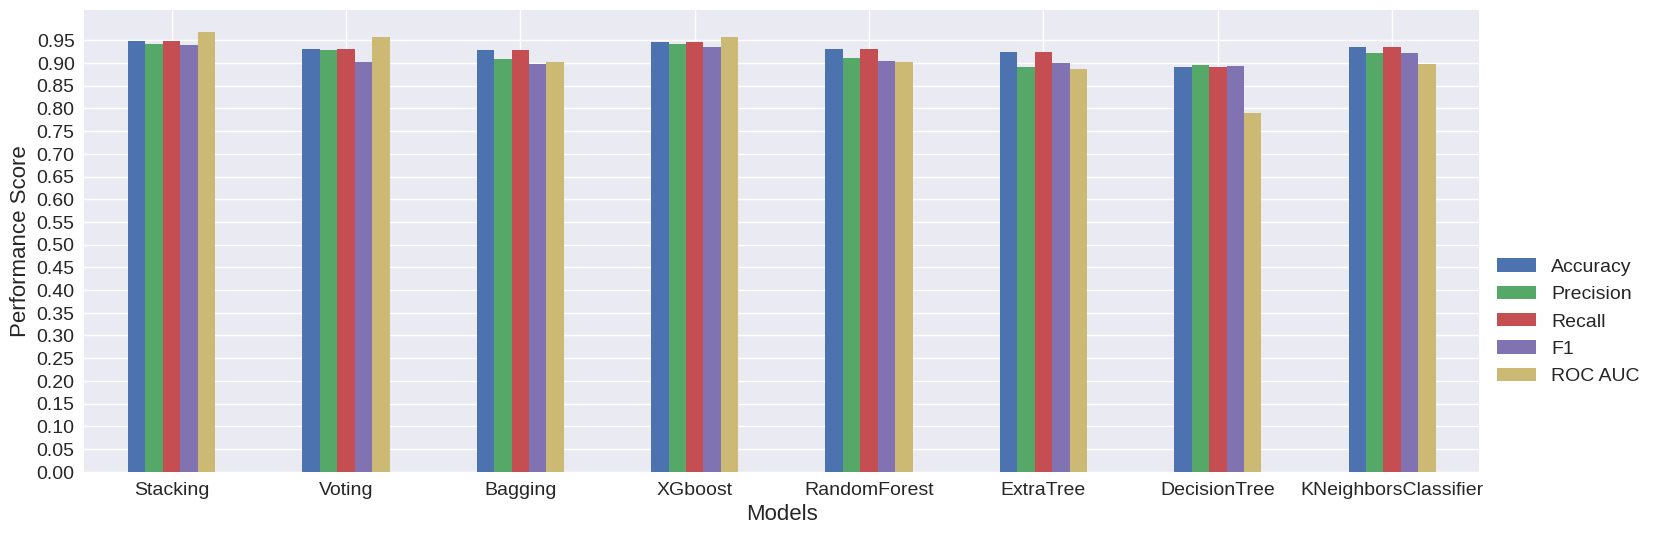

In [ ]:
res[["Accuracy","Precision","Recall","F1", "ROC AUC"]].plot.bar(figsize=(18,6))
# plt.title("Model Performance Comparison", size=20)
plt.xlabel("Models",size=16)
plt.ylabel("Performance Score",size=16)
plt.xticks(size=14,rotation = 0)
plt.yticks(np.arange(0,1,0.05),size=14)
plt.legend(loc='upper left', bbox_to_anchor=(1, 0.5),
          fancybox=True, shadow=True, fontsize=14)

# plt.savefig('ensemble_performance.png', dpi=300, bbox_inches='tight')
plt.show()

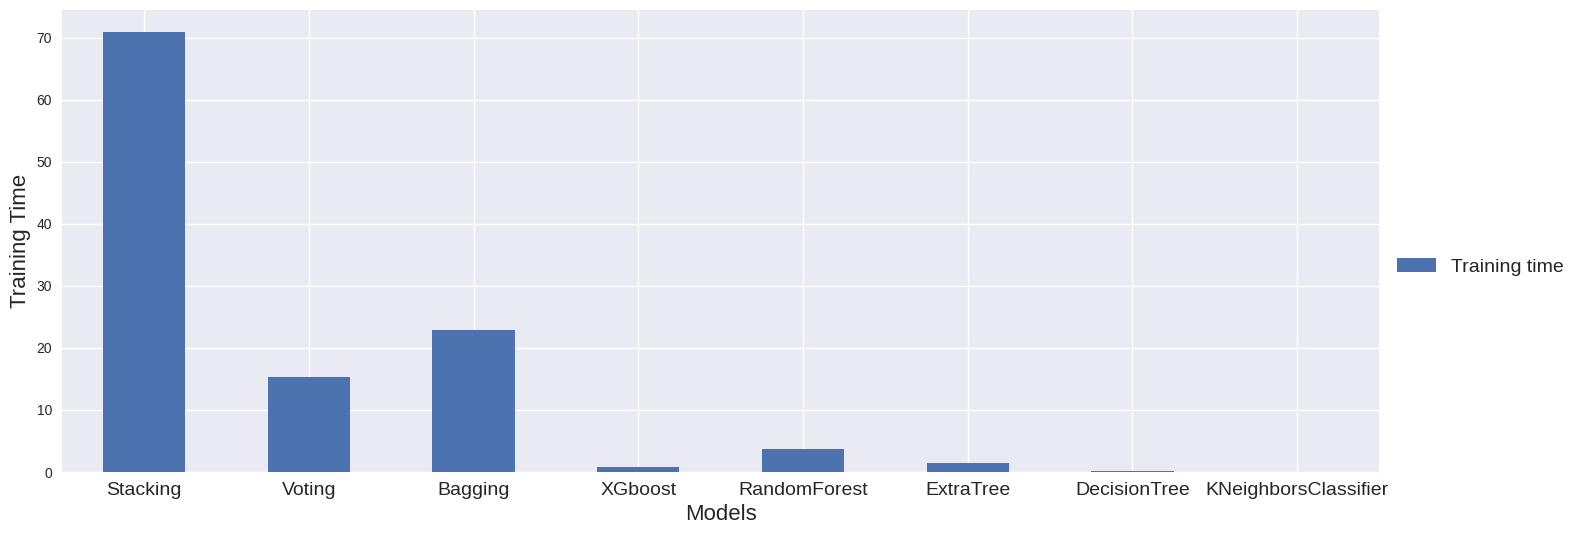

In [ ]:
res[["Training time"]].plot.bar(figsize=(17,6))
# plt.title("Model Performance Comparison", size=20)

plt.xlabel("Models",size=16)
plt.ylabel("Training Time",size=16)
plt.xticks(size=14,rotation = 0)
# plt.yticks(np.arange(0,100 + 0.5,0,5),size=14)
plt.legend(loc='upper left', bbox_to_anchor=(1, 0.5),
          fancybox=True, shadow=True, fontsize=14)

# plt.savefig('ensemble_performance.png', dpi=300, bbox_inches='tight')
plt.show()

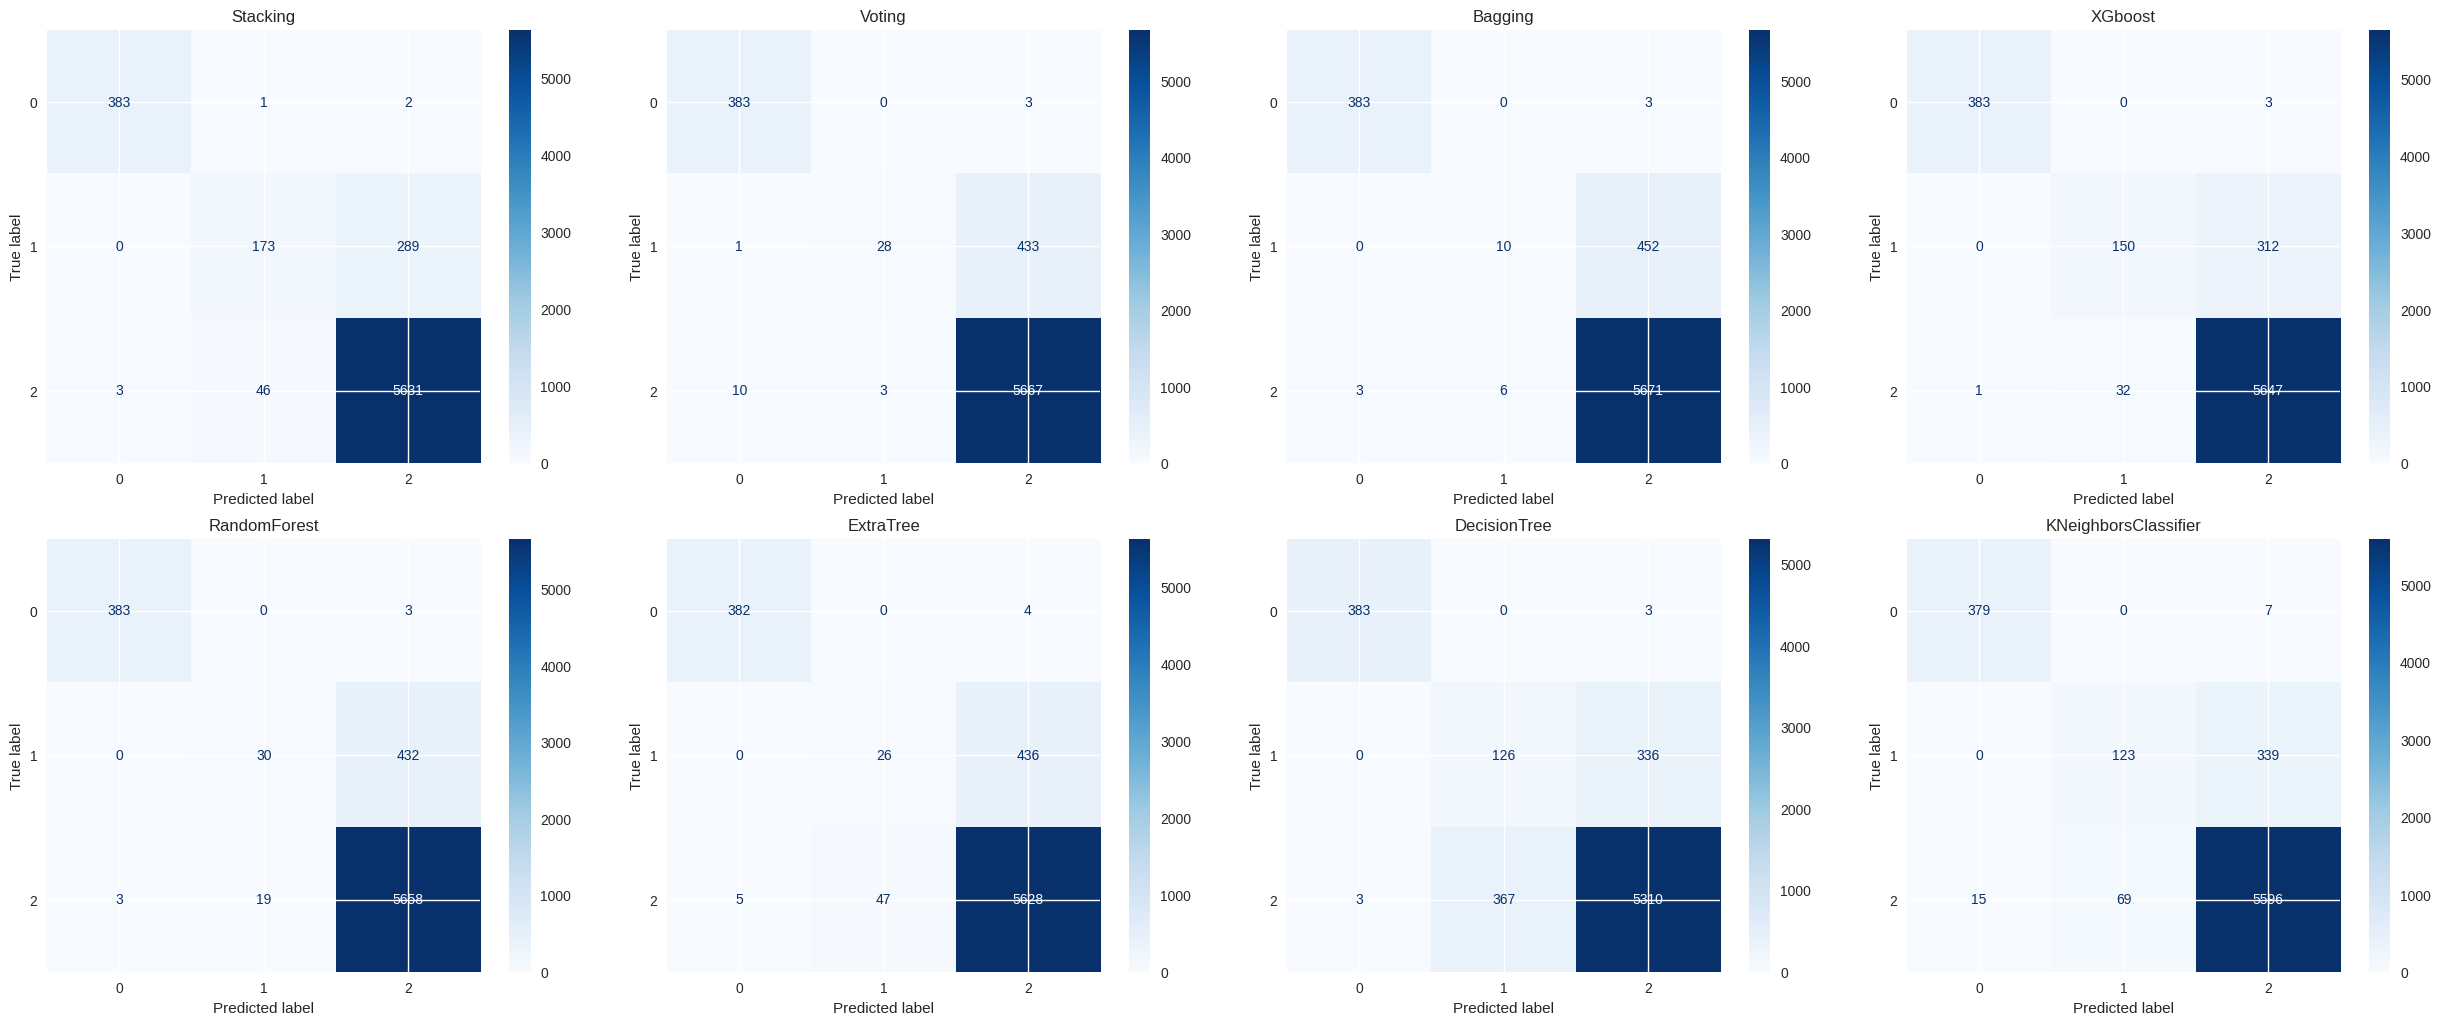

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Initialize dictionaries
# fpr, fdr, false_positive, false_negative = {}, {}, {}, {}

# List untuk menyimpan confusion matrix
cms = []

# Loop untuk menghitung confusion matrix untuk setiap model
for key in models.keys():
    # Compute confusion matrix
    cm = confusion_matrix(y_test, y_pred[key])
    cms.append((key, cm))

# Buat plot dengan subplots
num_models = len(models)
fig, axes = plt.subplots(nrows=3, ncols=(num_models + 1) // 2, figsize=(25, 15))

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Plot each confusion matrix
for idx, (key, cm) in enumerate(cms):
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y_test))
    disp.plot(cmap='Blues', ax=axes[idx], colorbar=True)
    axes[idx].set_title(key)

# Remove any unused axes (if any)
for idx in range(num_models, len(axes)):
    fig.delaxes(axes[idx])

# Adjust layout
plt.tight_layout()
plt.show()


In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Initialize dictionaries
fpr, fdr, false_positive, false_negative = {}, {}, {}, {}

for key in models.keys():
    # # Compute confusion matrix
    cm = confusion_matrix(y_test, y_pred[key])

    # # Plot confusion matrix
    # disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y_test))
    # disp.plot(cmap='Blues')
    # plt.title(key)
    # plt.show()

    # Calculate false positives, false negatives, FPR, and FDR for each class
    fp = cm.sum(axis=0) - np.diag(cm)
    fn = cm.sum(axis=1) - np.diag(cm)
    tp = np.diag(cm)
    tn = cm.sum() - (fp + fn + tp)

    false_positive[key] = fp
    false_negative[key] = fn
    fpr[key] = fp / (fp + tn) * 100
    fdr[key] = fp / (fp + tp) * 100

    print(f"{key} False Positives: {fp}")
    print(f"{key} False Negatives: {fn}")
    print(f"{key} FPR: {fpr[key]}")
    print(f"{key} FDR: {fdr[key]}")
    print("=============")

Stacking False Positives: [  3  47 291]
Stacking False Negatives: [  3 289  49]
Stacking FPR: [ 0.04884402  0.77481042 34.31603774]
Stacking FDR: [ 0.77720207 21.36363636  4.91388045]
Voting False Positives: [ 11   3 436]
Voting False Negatives: [  3 434  13]
Voting FPR: [1.79094757e-01 4.94559842e-02 5.14150943e+01]
Voting FDR: [2.79187817 9.67741935 7.14402753]
Bagging False Positives: [  3   6 455]
Bagging False Negatives: [  3 452   9]
Bagging FPR: [4.88440247e-02 9.89119683e-02 5.36556604e+01]
Bagging FDR: [ 0.77720207 37.5         7.4273588 ]
XGboost False Positives: [  1  32 315]
XGboost False Negatives: [  3 312  33]
XGboost FPR: [1.62813416e-02 5.27530498e-01 3.71462264e+01]
XGboost FDR: [ 0.26041667 17.58241758  5.28346193]
RandomForest False Positives: [  3  19 435]
RandomForest False Negatives: [  3 432  22]
RandomForest FPR: [4.88440247e-02 3.13221233e-01 5.12971698e+01]
RandomForest FDR: [ 0.77720207 38.7755102   7.13934023]
ExtraTree False Positives: [  5  47 440]
ExtraT

In [ ]:
print(fpr)

{'Stacking': array([ 0.04884402,  0.77481042, 34.31603774]), 'Voting': array([1.79094757e-01, 4.94559842e-02, 5.14150943e+01]), 'Bagging': array([4.88440247e-02, 9.89119683e-02, 5.36556604e+01]), 'XGboost': array([1.62813416e-02, 5.27530498e-01, 3.71462264e+01]), 'RandomForest': array([4.88440247e-02, 3.13221233e-01, 5.12971698e+01]), 'ExtraTree': array([ 0.08140671,  0.77481042, 51.88679245]), 'DecisionTree': array([ 0.04884402,  6.0501154 , 39.97641509]), 'KNeighborsClassifier': array([ 0.24422012,  1.13748764, 40.80188679])}


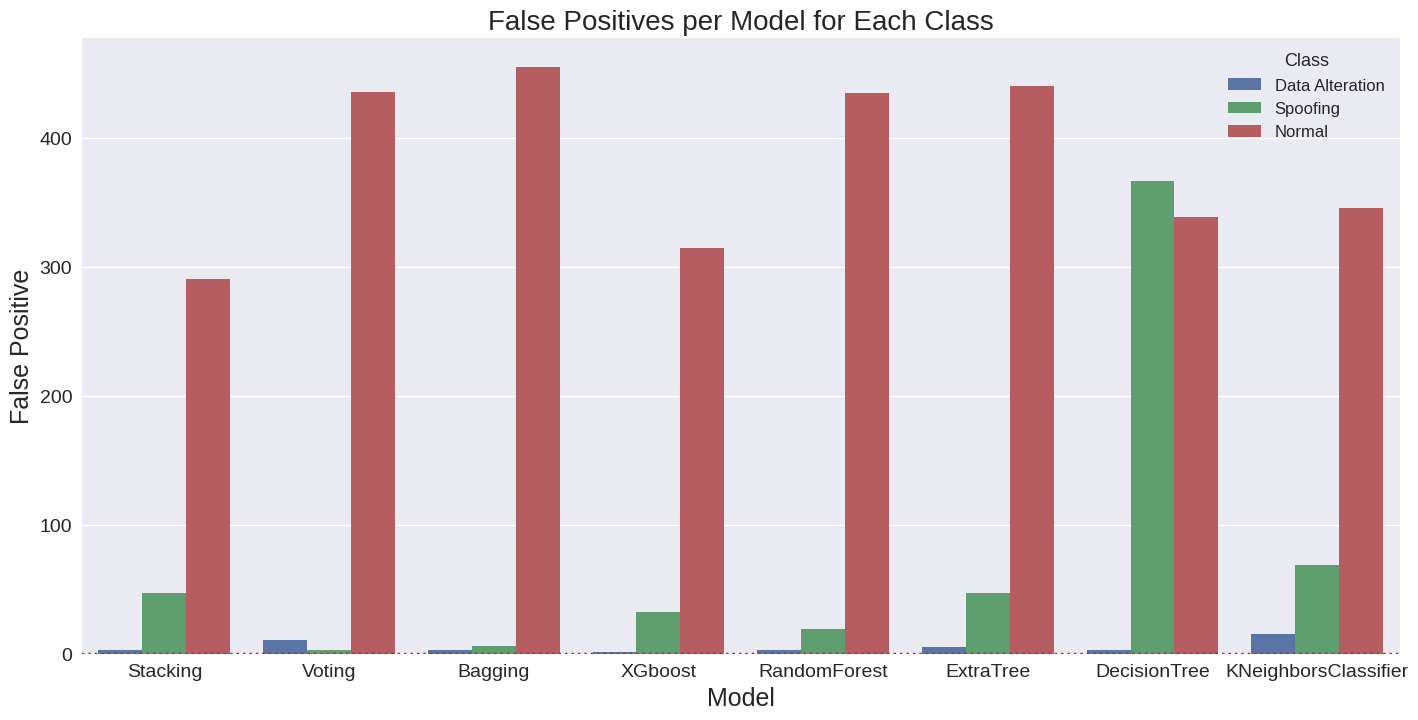

In [ ]:
# Extracting keys and values
false_p = list(false_positive.keys())
fp_values = np.array([false_positive[model] for model in false_p])
df_fp = pd.DataFrame(fp_values.T, columns=false_p)
df_fp['Class'] = ['Data Alteration', 'Spoofing', 'Normal']

# Melting the dataframe for seaborn
df_fp_melted = df_fp.melt(id_vars='Class', var_name='Model', value_name='False Positive')

# Plotting
plt.figure(figsize=(17, 8))
sns.barplot(x='Model', y='False Positive', hue='Class', data=df_fp_melted)
plt.xlabel('Model', size=18)
plt.ylabel('False Positive', size=18)
plt.xticks(size=14)
plt.yticks(size=14)
plt.axhline(color='r', linestyle=':')
plt.title('False Positives per Model for Each Class', size=20)
plt.legend(title='Class', title_fontsize='13', fontsize='12')
# plt.savefig('fp_performance.png', dpi=300, bbox_inches='tight')
plt.show()

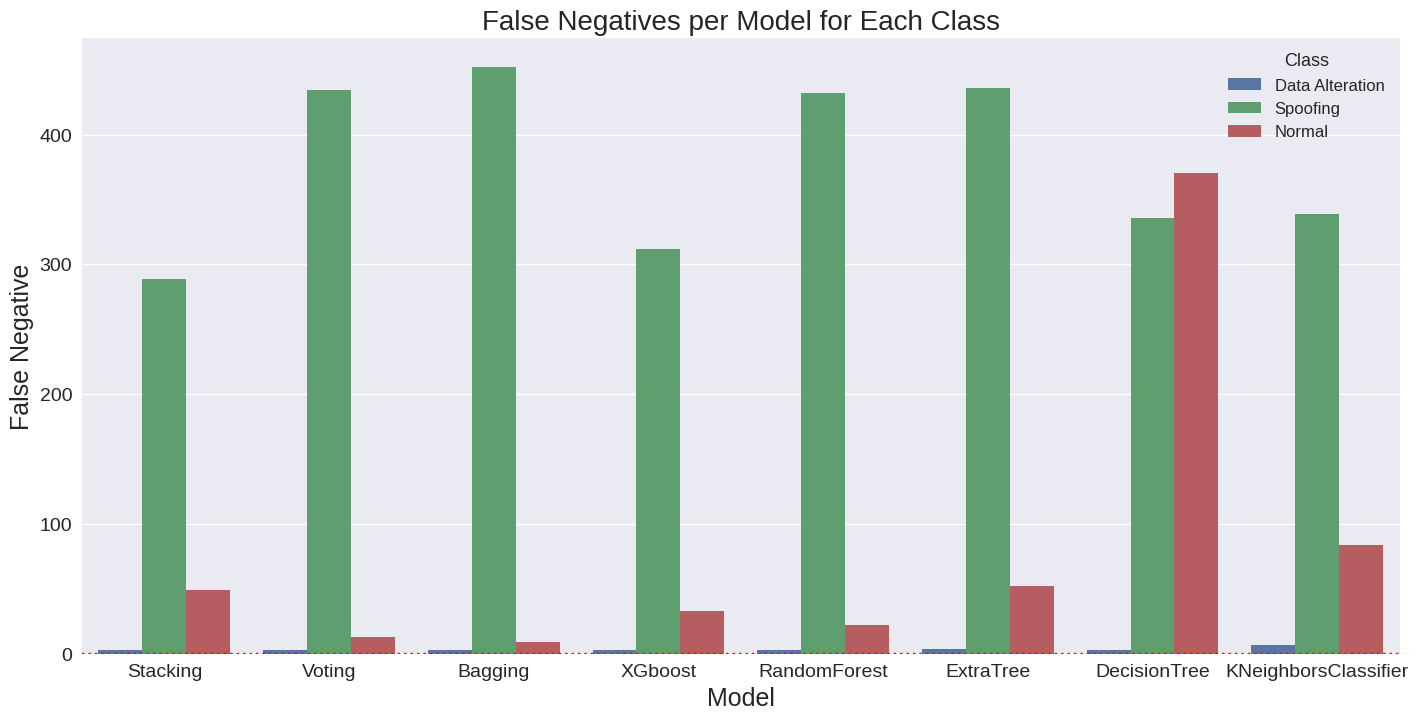

In [ ]:
# Extracting keys and values
false_n = list(false_negative.keys())
fp_values = np.array([false_negative[model] for model in false_n])
df_fp = pd.DataFrame(fp_values.T, columns=false_n)
df_fp['Class'] = ['Data Alteration', 'Spoofing', 'Normal']

# Melting the dataframe for seaborn
df_fp_melted = df_fp.melt(id_vars='Class', var_name='Model', value_name='False Negative')


plt.figure(figsize=(17, 8))
sns.barplot(x='Model', y='False Negative', hue='Class', data=df_fp_melted)
plt.xlabel('Model', size=18)
plt.ylabel('False Negative', size=18)
plt.xticks(size=14)
plt.yticks(size=14)
plt.axhline(color='r', linestyle=':')
plt.title('False Negatives per Model for Each Class', size=20)
plt.legend(title='Class', title_fontsize='13', fontsize='12')
# plt.savefig('fp_performance.png', dpi=300, bbox_inches='tight')
plt.show()

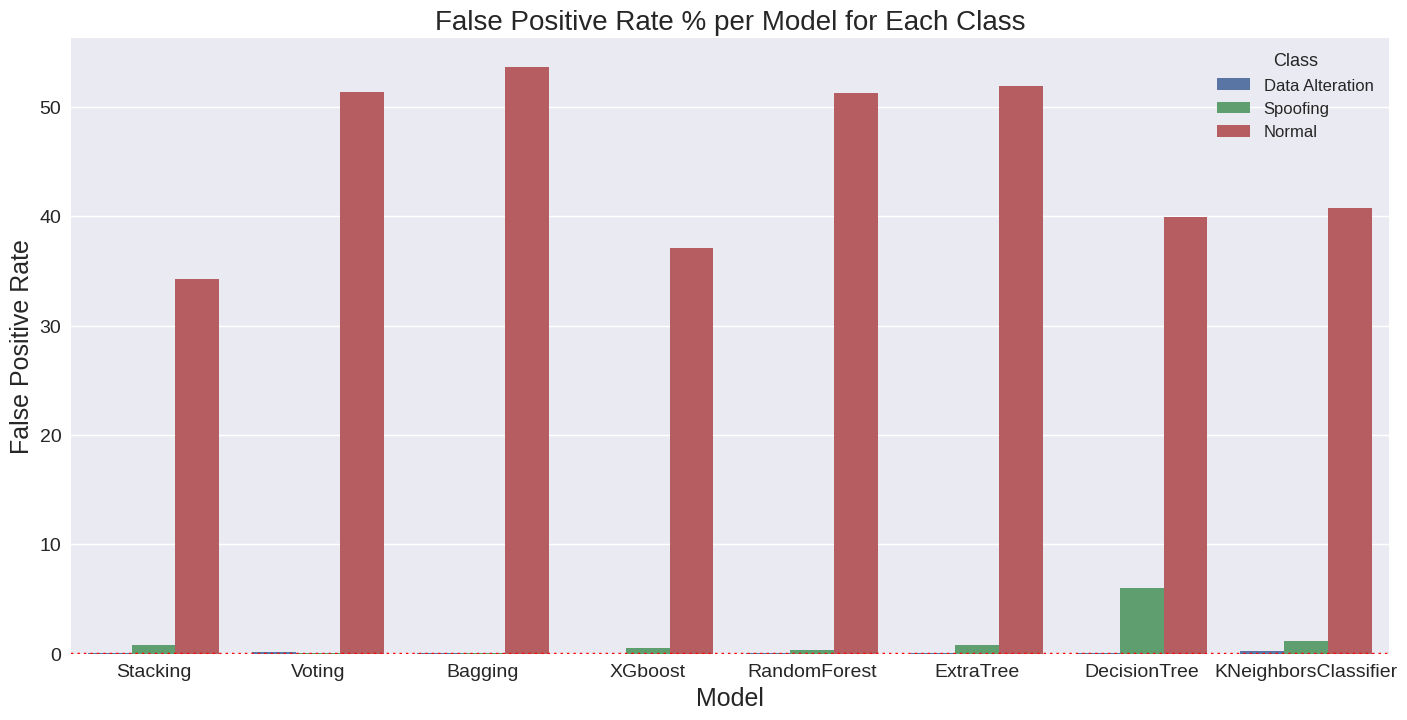

In [ ]:
# Extracting keys and values
false_pr = list(fpr.keys())
fp_values = np.array([fpr[model] for model in false_pr])
df_fp = pd.DataFrame(fp_values.T, columns=false_pr)
df_fp['Class'] = ['Data Alteration', 'Spoofing', 'Normal']

# Melting the dataframe for seaborn
df_fp_melted = df_fp.melt(id_vars='Class', var_name='Model', value_name='False Positive Rate')


plt.figure(figsize=(17, 8))
sns.barplot(x='Model', y='False Positive Rate', hue='Class', data=df_fp_melted)
plt.xlabel('Model', size=18)
plt.ylabel('False Positive Rate', size=18)
plt.xticks(size=14)
plt.yticks(size=14)
plt.axhline(color='r', linestyle=':')
plt.title('False Positive Rate % per Model for Each Class', size=20)
plt.legend(title='Class', title_fontsize='13', fontsize='12')
# plt.savefig('fp_performance.png', dpi=300, bbox_inches='tight')
plt.show()

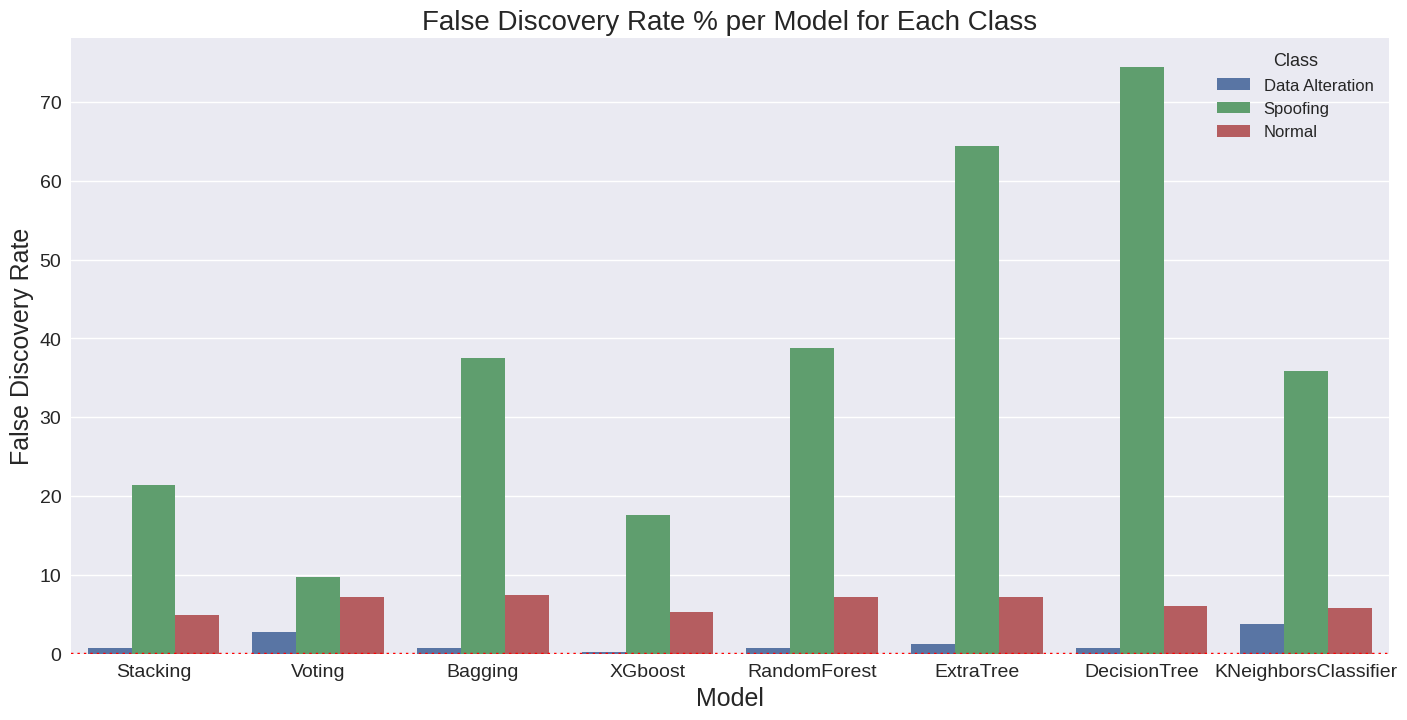

In [ ]:
# Extracting keys and values
false_dr = list(fdr.keys())
fp_values = np.array([fdr[model] for model in false_dr])
df_fp = pd.DataFrame(fp_values.T, columns=false_dr)
df_fp['Class'] = ['Data Alteration', 'Spoofing', 'Normal']

# Melting the dataframe for seaborn
df_fp_melted = df_fp.melt(id_vars='Class', var_name='Model', value_name='False Discovery Rate')


plt.figure(figsize=(17, 8))
sns.barplot(x='Model', y='False Discovery Rate', hue='Class', data=df_fp_melted)
plt.xlabel('Model', size=18)
plt.ylabel('False Discovery Rate', size=18)
plt.xticks(size=14)
plt.yticks(size=14)
plt.axhline(color='r', linestyle=':')
plt.title('False Discovery Rate % per Model for Each Class', size=20)
plt.legend(title='Class', title_fontsize='13', fontsize='12')
# plt.savefig('fp_performance.png', dpi=300, bbox_inches='tight')
plt.show()

# **Model Training** *scenario 4*

Keterangan:

*   Dengan split train and test 5:5



In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score
from sklearn.ensemble import StackingClassifier, VotingClassifier, RandomForestClassifier, ExtraTreesClassifier, BaggingClassifier
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
# from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.svm import SVC
from sklearn.naive_bayes import BernoulliNB
from sklearn.neural_network import MLPClassifier
import time
import pickle

# Definisi model
models = {}

estimators = [
    ('KNN', KNeighborsClassifier(n_jobs=-1)),
    ('SVC', SVC(probability=True)),  # Tambahkan probability=True untuk SVC
    ('xgb', XGBClassifier()),
    ('NBB', BernoulliNB()),
    ('MLP', MLPClassifier(hidden_layer_sizes=(50,), max_iter=100, activation='relu', solver='adam', random_state=42))
]

models['Stacking'] = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression(max_iter=50))
models['Voting'] = VotingClassifier(estimators=estimators, voting='soft')  # Ubah voting='hard' ke voting='soft'
models['Bagging'] = BaggingClassifier(base_estimator=RandomForestClassifier())
models['XGboost'] = XGBClassifier()
models['RandomForest'] = RandomForestClassifier()
models['ExtraTree'] = ExtraTreesClassifier()
models['DecisionTree'] = DecisionTreeClassifier()
models['KNeighborsClassifier'] = KNeighborsClassifier()
# models['RidgeClassifier'] = RidgeClassifier(alpha=1.0, solver='auto')

# Inisialisasi metrik evaluasi
train_score, accuracy, precision, recall, f1, rocauc, training_time, y_pred, predict_time = {}, {}, {}, {}, {}, {}, {}, {}, {}

# Evaluasi setiap model
for key in models.keys():
    start_time_t = time.time()
    models[key].fit(x_train, y_train)
    training_time[key] = time.time() - start_time_t

    trained_model_name = f'/content/drive/MyDrive/Abc/trained5/{key}.pkl'
    with open(trained_model_name, 'wb') as file:
        pickle.dump(models[key], file)

    start_time_p = time.time()
    y_pred[key] = models[key].predict(x_test)
    predict_time[key] = time.time() - start_time_p

    train_score[key] = models[key].score(x_train, y_train)
    accuracy[key] = models[key].score(x_test, y_test)
    precision[key] = precision_score(y_test, y_pred[key], average='weighted')
    recall[key] = recall_score(y_test, y_pred[key], average='weighted')
    # rocauc[key] = sklearn.metrics.roc_auc_score(y_test, y_pred[key])
    if key == 'Voting' or key == 'Stacking':
        rocauc[key] = roc_auc_score(y_test, models[key].predict_proba(x_test), multi_class='ovo')
    else:
        rocauc[key] = roc_auc_score(y_test, models[key].predict_proba(x_test), multi_class='ovr')

    f1[key] = f1_score(y_test, y_pred[key], average='weighted')

# Output hasil evaluasi
print("Train Score:", train_score)
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("ROC AUC:", rocauc)
print("Training Time:", training_time)
print("Predict Time:", predict_time)


Train Score: {'Stacking': 0.9825959063610736, 'Voting': 0.9388405441843363, 'Bagging': 0.96727540139723, 'XGboost': 0.9832087265596274, 'RandomForest': 1.0, 'ExtraTree': 1.0, 'DecisionTree': 1.0, 'KNeighborsClassifier': 0.9506066919965682}
Accuracy: {'Stacking': 0.9461943865669813, 'Voting': 0.9350410589533031, 'Bagging': 0.9311190096825591, 'XGboost': 0.9449687461698738, 'RandomForest': 0.9309964456428483, 'ExtraTree': 0.9278097806103689, 'DecisionTree': 0.8914082608162766, 'KNeighborsClassifier': 0.9311190096825591}
Precision: {'Stacking': 0.9383915473827639, 'Voting': 0.9320149886592078, 'Bagging': 0.9080197770986576, 'XGboost': 0.9378856832622869, 'RandomForest': 0.9045889430475834, 'ExtraTree': 0.8990888484415792, 'DecisionTree': 0.8988681574662554, 'KNeighborsClassifier': 0.9161944871453184}
Recall: {'Stacking': 0.9461943865669813, 'Voting': 0.9350410589533031, 'Bagging': 0.9311190096825591, 'XGboost': 0.9449687461698738, 'RandomForest': 0.9309964456428483, 'ExtraTree': 0.9278097

In [ ]:
res = pd.DataFrame(index=models.keys(), columns=['Training score', 'Accuracy', 'Precision', 'Recall', 'F1' ,'Training time', 'Predict Time'])
res['Training score'] = train_score.values()
res['Accuracy'] = accuracy.values()
res['Precision'] = precision.values()
res['Recall'] = recall.values()
res['ROC AUC'] = rocauc.values()
res['F1'] = f1.values()
res['Training time'] = training_time.values()
res['Predict Time'] = predict_time.values()
res = res.round(4)
res

,Training score,Accuracy,Precision,Recall,F1,Training time,Predict Time,ROC AUC
Stacking,0.9824,0.9434,0.9345,0.9434,0.9348,55.1156,1.3693,0.9625
Voting,0.9376,0.9334,0.9340,0.9334,0.9060,12.2480,1.3132,0.9526
Bagging,0.9658,0.9301,0.8991,0.9301,0.8988,14.9650,1.3823,0.8940
XGboost,0.9801,0.9409,0.9309,0.9409,0.9298,0.6435,0.0453,0.9475
RandomForest,1.0000,0.9308,0.9059,0.9308,0.9039,2.0410,0.1290,0.8894
ExtraTree,1.0000,0.9270,0.8926,0.9270,0.9019,0.7427,0.1743,0.8827
DecisionTree,1.0000,0.8876,0.8991,0.8876,0.8931,0.1328,0.0030,0.7948
KNeighborsClassifier,0.9491,0.9337,0.9200,0.9337,0.9222,0.0027,0.8057,0.8926


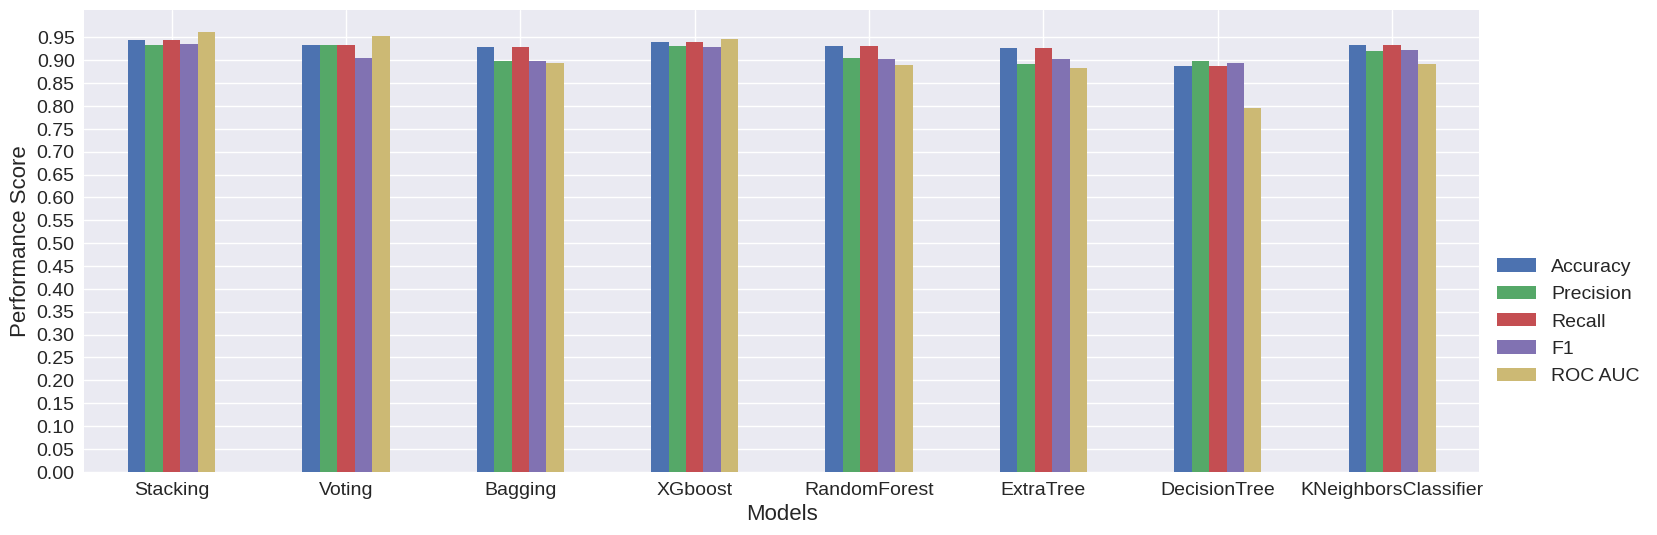

In [ ]:
res[["Accuracy","Precision","Recall","F1", "ROC AUC"]].plot.bar(figsize=(18,6))
# plt.title("Model Performance Comparison", size=20)
plt.xlabel("Models",size=16)
plt.ylabel("Performance Score",size=16)
plt.xticks(size=14,rotation = 0)
plt.yticks(np.arange(0,1,0.05),size=14)
plt.legend(loc='upper left', bbox_to_anchor=(1, 0.5),
          fancybox=True, shadow=True, fontsize=14)

# plt.savefig('ensemble_performance.png', dpi=300, bbox_inches='tight')
plt.show()

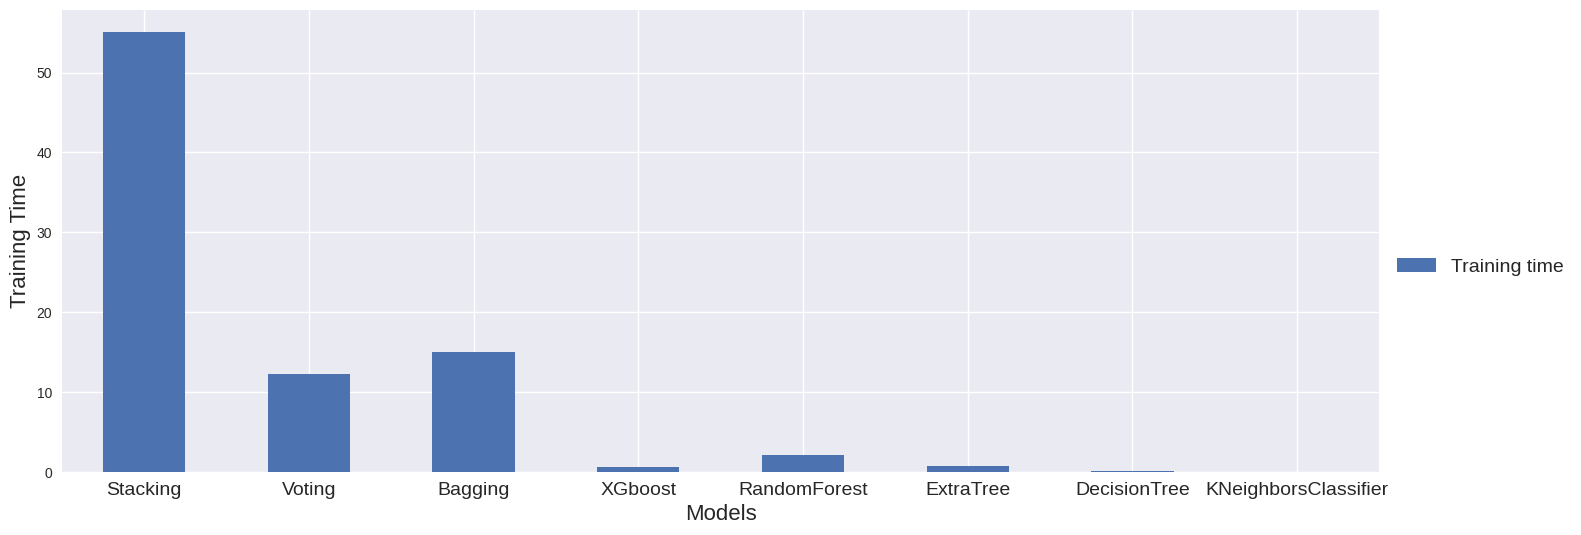

In [ ]:
res[["Training time"]].plot.bar(figsize=(17,6))
# plt.title("Model Performance Comparison", size=20)

plt.xlabel("Models",size=16)
plt.ylabel("Training Time",size=16)
plt.xticks(size=14,rotation = 0)
# plt.yticks(np.arange(0,100 + 0.5,0,5),size=14)
plt.legend(loc='upper left', bbox_to_anchor=(1, 0.5),
          fancybox=True, shadow=True, fontsize=14)

# plt.savefig('ensemble_performance.png', dpi=300, bbox_inches='tight')
plt.show()

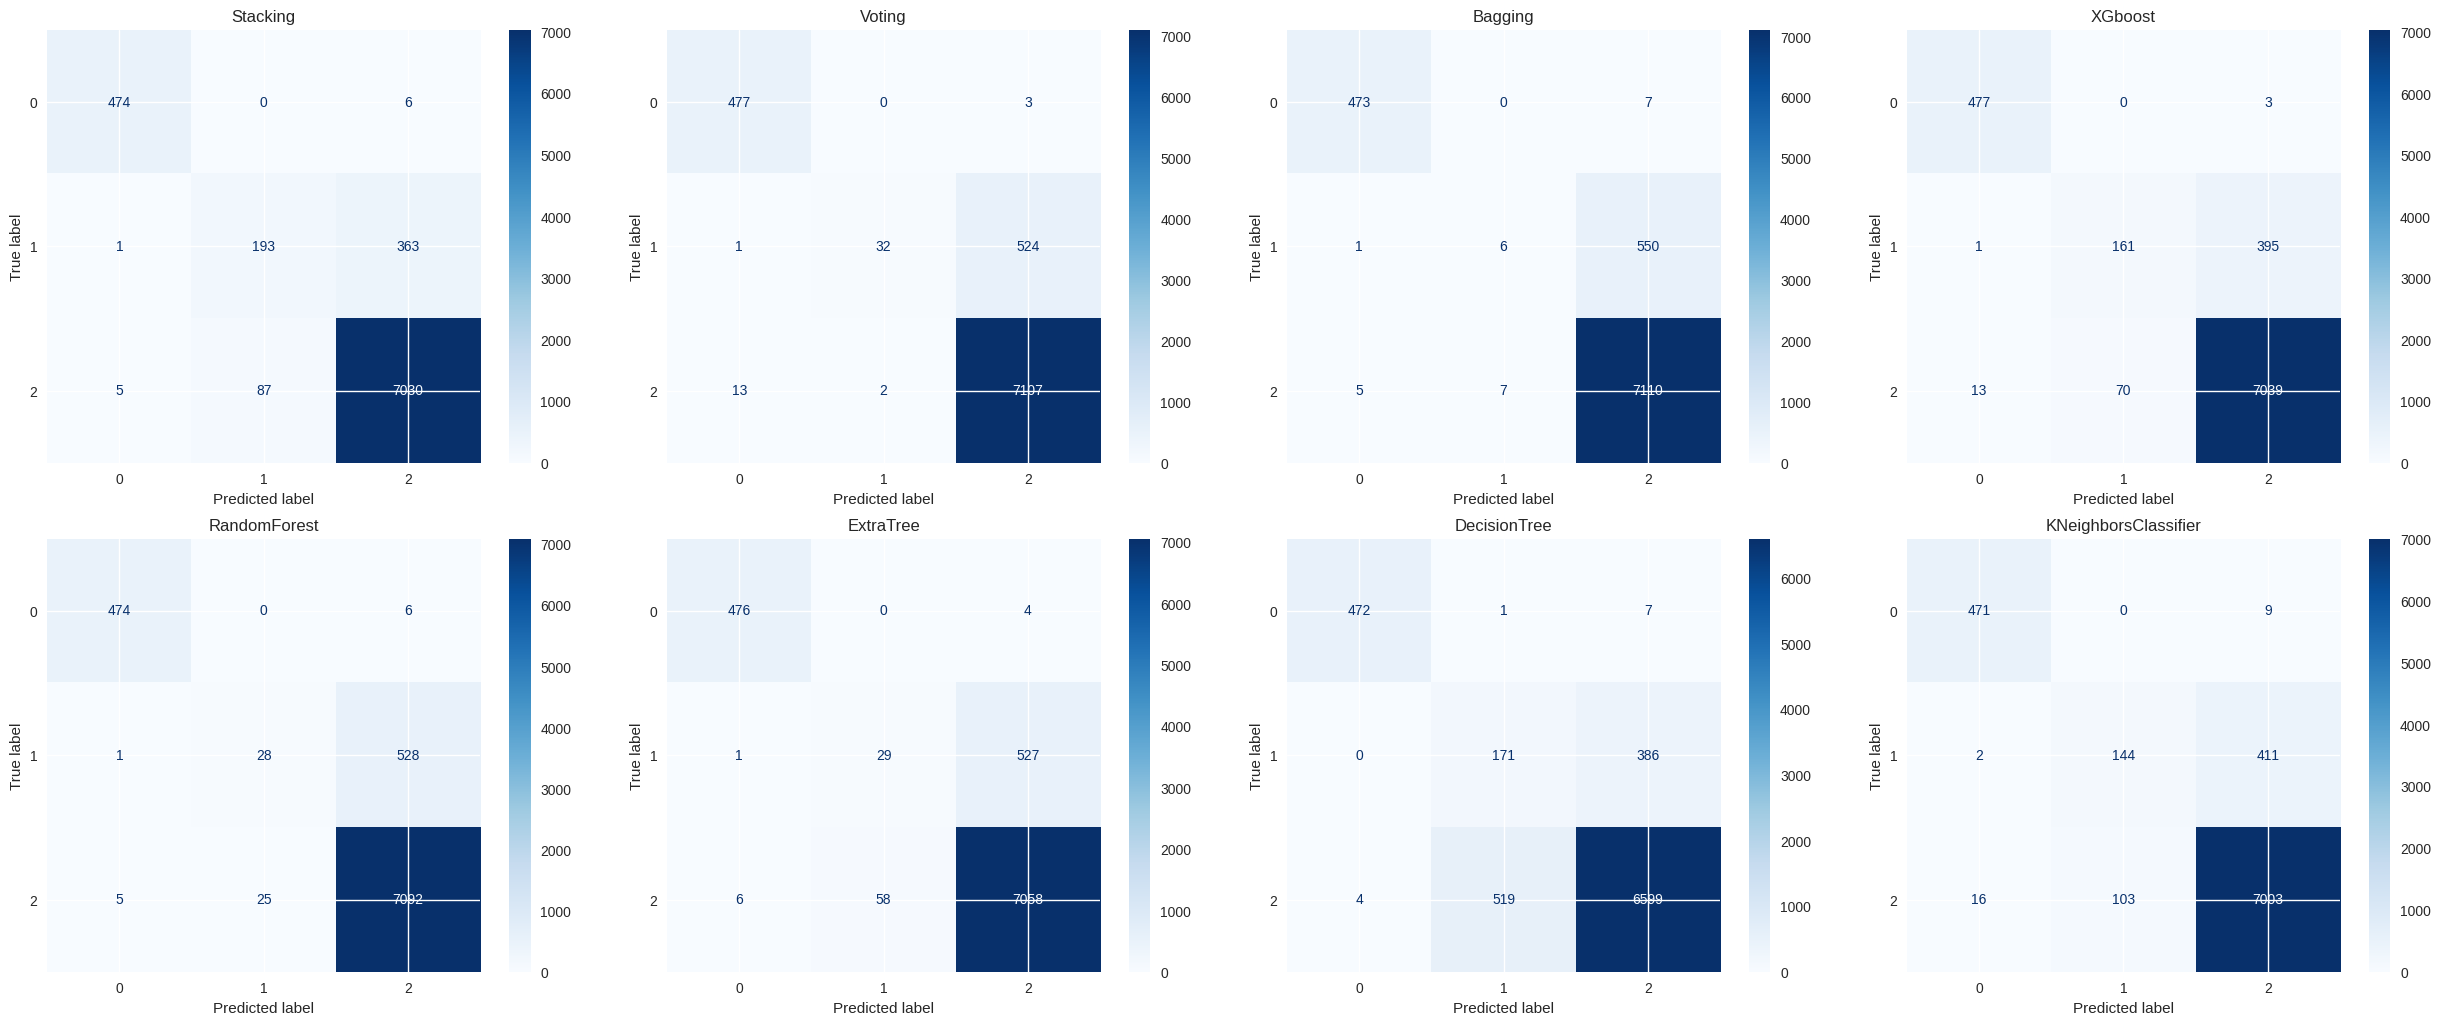

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Initialize dictionaries
# fpr, fdr, false_positive, false_negative = {}, {}, {}, {}

# List untuk menyimpan confusion matrix
cms = []

# Loop untuk menghitung confusion matrix untuk setiap model
for key in models.keys():
    # Compute confusion matrix
    cm = confusion_matrix(y_test, y_pred[key])
    cms.append((key, cm))

# Buat plot dengan subplots
num_models = len(models)
fig, axes = plt.subplots(nrows=3, ncols=(num_models + 1) // 2, figsize=(25, 15))

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Plot each confusion matrix
for idx, (key, cm) in enumerate(cms):
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y_test))
    disp.plot(cmap='Blues', ax=axes[idx], colorbar=True)
    axes[idx].set_title(key)

# Remove any unused axes (if any)
for idx in range(num_models, len(axes)):
    fig.delaxes(axes[idx])

# Adjust layout
plt.tight_layout()
plt.show()


In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Initialize dictionaries
fpr, fdr, false_positive, false_negative = {}, {}, {}, {}

for key in models.keys():
    # # Compute confusion matrix
    cm = confusion_matrix(y_test, y_pred[key])

    # # Plot confusion matrix
    # disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y_test))
    # disp.plot(cmap='Blues')
    # plt.title(key)
    # plt.show()

    # Calculate false positives, false negatives, FPR, and FDR for each class
    fp = cm.sum(axis=0) - np.diag(cm)
    fn = cm.sum(axis=1) - np.diag(cm)
    tp = np.diag(cm)
    tn = cm.sum() - (fp + fn + tp)

    false_positive[key] = fp
    false_negative[key] = fn
    fpr[key] = fp / (fp + tn) * 100
    fdr[key] = fp / (fp + tp) * 100

    print(f"{key} False Positives: {fp}")
    print(f"{key} False Negatives: {fn}")
    print(f"{key} FPR: {fpr[key]}")
    print(f"{key} FDR: {fdr[key]}")
    print("=============")

Stacking False Positives: [  6  87 369]
Stacking False Negatives: [  6 364  92]
Stacking FPR: [ 0.07813517  1.14443567 35.58341369]
Stacking FDR: [ 1.25       31.07142857  4.98716043]
Voting False Positives: [ 14   2 527]
Voting False Negatives: [  3 525  15]
Voting FPR: [1.82315406e-01 2.63088661e-02 5.08196721e+01]
Voting FDR: [2.85132383 5.88235294 6.90332722]
Bagging False Positives: [  6   7 557]
Bagging False Negatives: [  7 551  12]
Bagging FPR: [ 0.07813517  0.09208103 53.71263259]
Bagging FDR: [ 1.2526096  53.84615385  7.26490153]
XGboost False Positives: [ 14  70 398]
XGboost False Negatives: [  3 396  83]
XGboost FPR: [ 0.18231541  0.92081031 38.37994214]
XGboost FDR: [ 2.85132383 30.3030303   5.35162028]
RandomForest False Positives: [  6  25 534]
RandomForest False Negatives: [  6 529  30]
RandomForest FPR: [ 0.07813517  0.32886083 51.49469624]
RandomForest FDR: [ 1.25       47.16981132  7.00236035]
ExtraTree False Positives: [  7  58 531]
ExtraTree False Negatives: [  4 5

In [ ]:
print(fpr)

{'Stacking': array([ 0.07813517,  1.14443567, 35.58341369]), 'Voting': array([1.82315406e-01, 2.63088661e-02, 5.08196721e+01]), 'Bagging': array([ 0.07813517,  0.09208103, 53.71263259]), 'XGboost': array([ 0.18231541,  0.92081031, 38.37994214]), 'RandomForest': array([ 0.07813517,  0.32886083, 51.49469624]), 'ExtraTree': array([ 0.0911577 ,  0.76295712, 51.20540019]), 'DecisionTree': array([ 0.05209012,  6.84030518, 37.89778206]), 'KNeighborsClassifier': array([ 0.23440552,  1.3549066 , 40.50144648])}


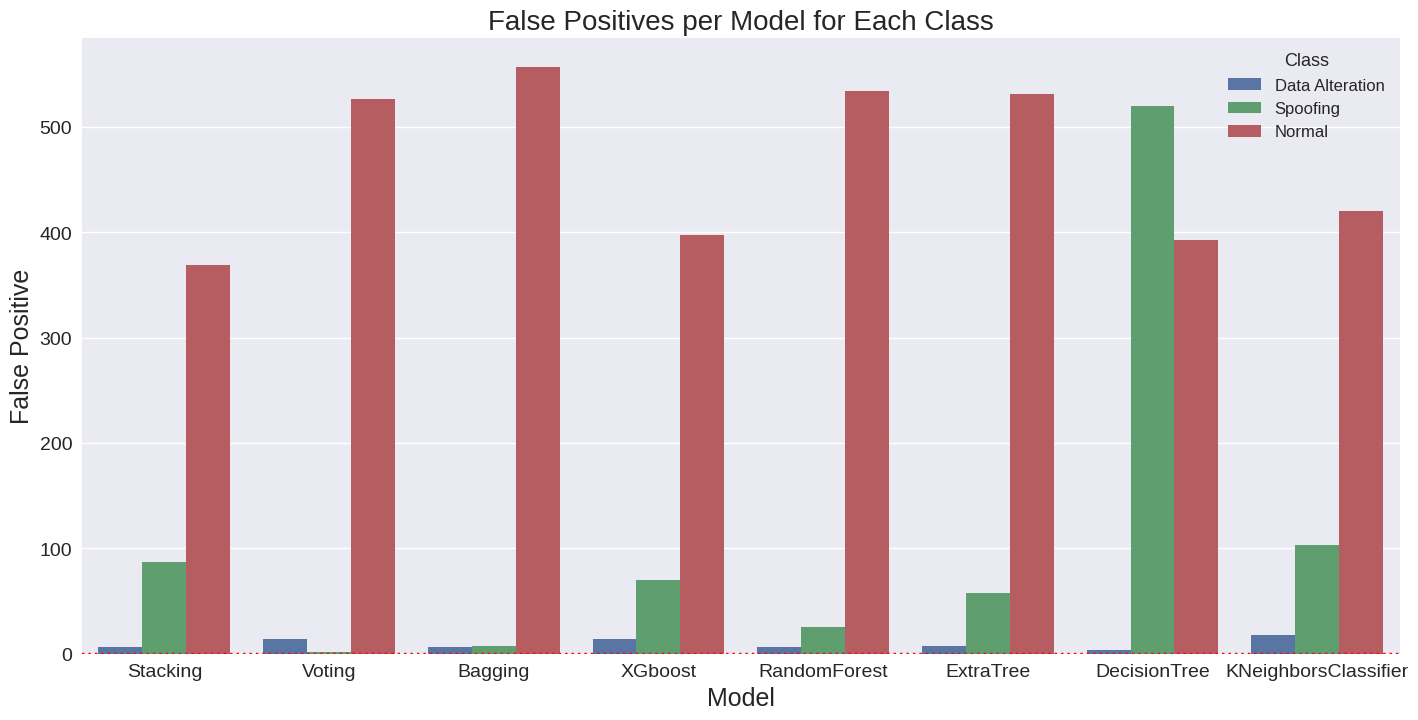

In [ ]:
# Extracting keys and values
false_p = list(false_positive.keys())
fp_values = np.array([false_positive[model] for model in false_p])
df_fp = pd.DataFrame(fp_values.T, columns=false_p)
df_fp['Class'] = ['Data Alteration', 'Spoofing', 'Normal']

# Melting the dataframe for seaborn
df_fp_melted = df_fp.melt(id_vars='Class', var_name='Model', value_name='False Positive')

# Plotting
plt.figure(figsize=(17, 8))
sns.barplot(x='Model', y='False Positive', hue='Class', data=df_fp_melted)
plt.xlabel('Model', size=18)
plt.ylabel('False Positive', size=18)
plt.xticks(size=14)
plt.yticks(size=14)
plt.axhline(color='r', linestyle=':')
plt.title('False Positives per Model for Each Class', size=20)
plt.legend(title='Class', title_fontsize='13', fontsize='12')
# plt.savefig('fp_performance.png', dpi=300, bbox_inches='tight')
plt.show()

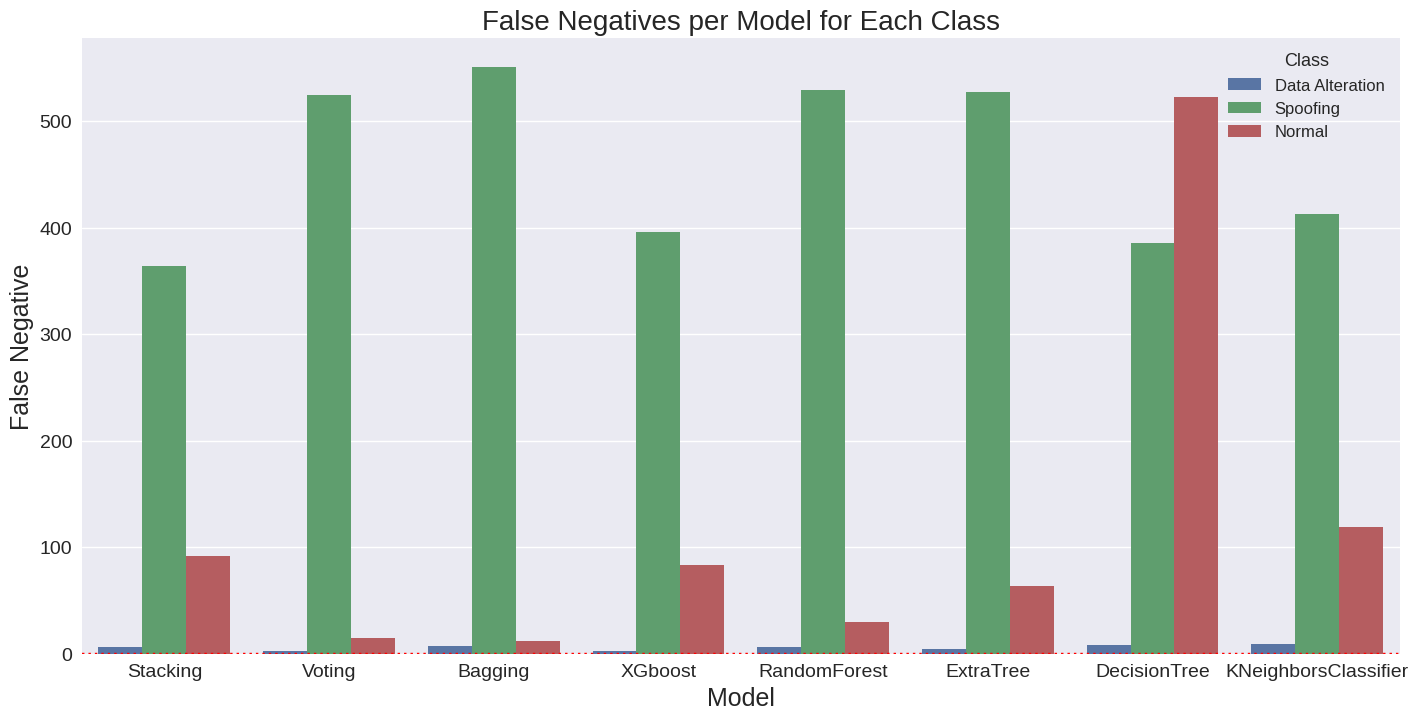

In [ ]:
# Extracting keys and values
false_n = list(false_negative.keys())
fp_values = np.array([false_negative[model] for model in false_n])
df_fp = pd.DataFrame(fp_values.T, columns=false_n)
df_fp['Class'] = ['Data Alteration', 'Spoofing', 'Normal']

# Melting the dataframe for seaborn
df_fp_melted = df_fp.melt(id_vars='Class', var_name='Model', value_name='False Negative')


plt.figure(figsize=(17, 8))
sns.barplot(x='Model', y='False Negative', hue='Class', data=df_fp_melted)
plt.xlabel('Model', size=18)
plt.ylabel('False Negative', size=18)
plt.xticks(size=14)
plt.yticks(size=14)
plt.axhline(color='r', linestyle=':')
plt.title('False Negatives per Model for Each Class', size=20)
plt.legend(title='Class', title_fontsize='13', fontsize='12')
# plt.savefig('fp_performance.png', dpi=300, bbox_inches='tight')
plt.show()

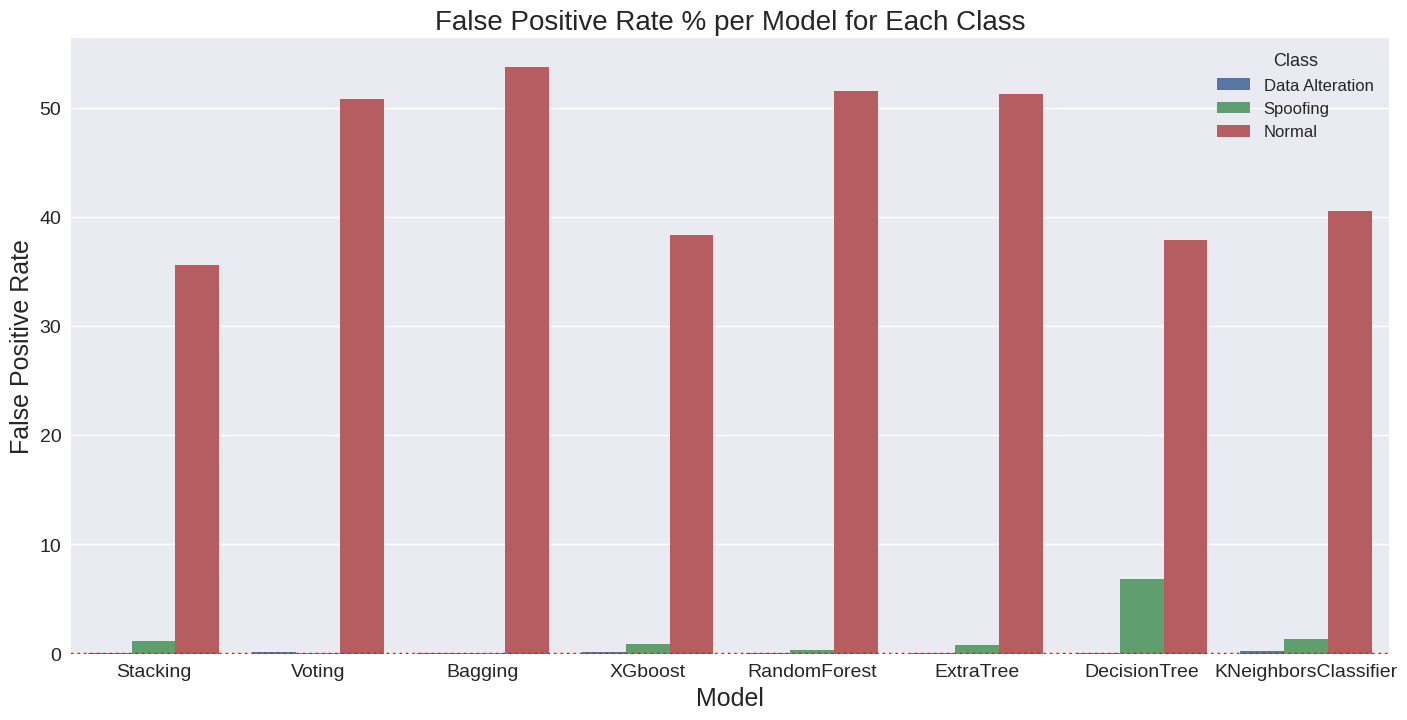

In [ ]:
# Extracting keys and values
false_pr = list(fpr.keys())
fp_values = np.array([fpr[model] for model in false_pr])
df_fp = pd.DataFrame(fp_values.T, columns=false_pr)
df_fp['Class'] = ['Data Alteration', 'Spoofing', 'Normal']

# Melting the dataframe for seaborn
df_fp_melted = df_fp.melt(id_vars='Class', var_name='Model', value_name='False Positive Rate')


plt.figure(figsize=(17, 8))
sns.barplot(x='Model', y='False Positive Rate', hue='Class', data=df_fp_melted)
plt.xlabel('Model', size=18)
plt.ylabel('False Positive Rate', size=18)
plt.xticks(size=14)
plt.yticks(size=14)
plt.axhline(color='r', linestyle=':')
plt.title('False Positive Rate % per Model for Each Class', size=20)
plt.legend(title='Class', title_fontsize='13', fontsize='12')
# plt.savefig('fp_performance.png', dpi=300, bbox_inches='tight')
plt.show()

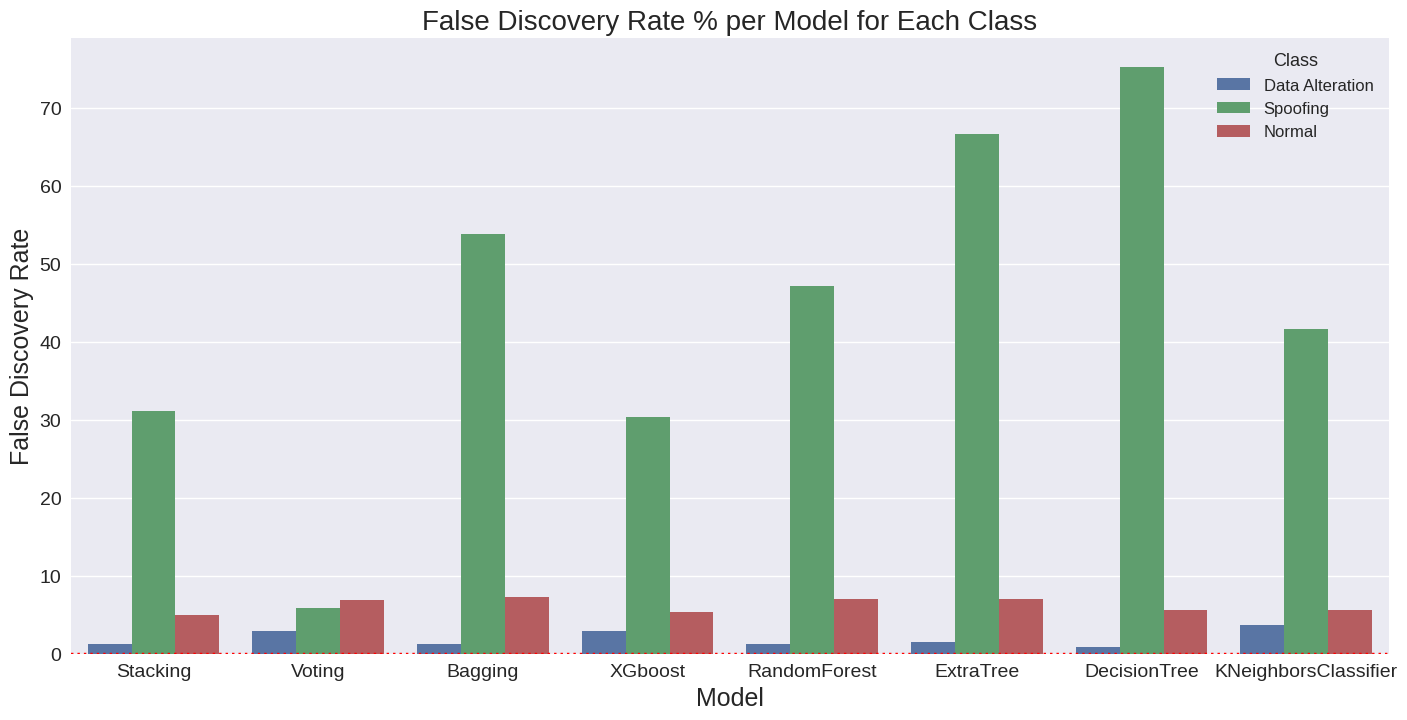

In [ ]:
# Extracting keys and values
false_dr = list(fdr.keys())
fp_values = np.array([fdr[model] for model in false_dr])
df_fp = pd.DataFrame(fp_values.T, columns=false_dr)
df_fp['Class'] = ['Data Alteration', 'Spoofing', 'Normal']

# Melting the dataframe for seaborn
df_fp_melted = df_fp.melt(id_vars='Class', var_name='Model', value_name='False Discovery Rate')


plt.figure(figsize=(17, 8))
sns.barplot(x='Model', y='False Discovery Rate', hue='Class', data=df_fp_melted)
plt.xlabel('Model', size=18)
plt.ylabel('False Discovery Rate', size=18)
plt.xticks(size=14)
plt.yticks(size=14)
plt.axhline(color='r', linestyle=':')
plt.title('False Discovery Rate % per Model for Each Class', size=20)
plt.legend(title='Class', title_fontsize='13', fontsize='12')
# plt.savefig('fp_performance.png', dpi=300, bbox_inches='tight')
plt.show()